## 0.0 IMPORTS

In [1]:
import pandas as pd
import inflection 
import math
import pickle
import json
from datetime import datetime
import numpy as np
import seaborn as sns
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from scipy import stats as ss
from IPython.core.display import HTML
from matplotlib import pyplot as plt
from IPython.display import Image
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

In [2]:
!pip show pickle

### 0.1 Helper Functions

In [3]:
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('Kfold Number:{}'.format(k))
    # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
    # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date']<= validation_end_date)]
        # training dataset
        xtraining = training.drop(['date','sales'],axis =1)
        ytraining = training['sales']
        # validation dataset
        xvalidation = validation.drop(['date','sales'],axis =1)
        yvalidation = validation['sales']
    
    #model
        m = model.fit(xtraining,ytraining)
    
    #prediciton
        yhat = m.predict(xvalidation)
    
    #performance
        m_result = ml_error(model_name,np.expm1(yvalidation),np.expm1(yhat))
    #store performance of each kfold   
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'MAE CV': np.round(np.mean(mae_list),2).astype(str) + '+/-' +  np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + '+/-' +  np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + '+/-' +  np.round(np.std(rmse_list),2).astype(str)},index =[0])
def cramer_v( x, y ):
 cm = pd.crosstab( x, y ).to_numpy()
 n = cm.sum()
 r, k = cm.shape
 chi2 = ss.chi2_contingency( cm )[0]
 chi2corr = max( 0, chi2- (k-1)*(r-1)/(n-1) )
 kcorr = k- (k-1)**2/(n-1)
 rcorr = r- (r-1)**2/(n-1)
 return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )
def mean_percentage_error(y,yhat):
    return np.mean((y-yhat)/y)
def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y-yhat)/y))
def ml_error(model_name, y ,yhat):
    mae=mean_absolute_error(y,yhat)
    mape=mean_absolute_percentage_error(y,yhat)
    rmse=np.sqrt(mean_squared_error(y,yhat))
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE':mape,
                         'RMSE':rmse},index=[0])
def jupyter_settings():
 %matplotlib inline
 %pylab inline
 plt.style.use( 'bmh' )
 plt.rcParams['figure.figsize'] = [25, 12]
 plt.rcParams['font.size'] = 24
 display( HTML( '<style>.container { width:100% !important; }</style>') )
 pd.options.display.max_columns = None
 pd.options.display.max_rows = None
 pd.set_option( 'display.expand_frame_repr', False )
 sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### 0.2 Loading data

In [4]:
df_sales_raw = pd.read_csv(r'train.rossmann.csv',low_memory = False)
df_store_raw = pd.read_csv(r'store.csv',low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how ='left', on = 'Store')

## 1.0 Data Description

In [5]:
df1 = df_raw.copy()

In [6]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

### 1.1 Rename Columns

In [7]:
df_raw.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))

In [9]:
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [10]:
print('Rows:{}'.format(df1.shape[0]))
print('Columns:{}'.format(df1.shape[1]))

Rows:1017209
Columns:18


In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.2 Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [14]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x:200000 if math.isnan(x) else x)
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis = 1)
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis = 1)
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis = 1)
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis = 1)

#promo_interval
month_map={1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec',}
df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval','month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [15]:

df1.isna().sum()
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.3 Change Types

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.4 Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes(include = ['int64','int32','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','int32','float64','datetime64[ns]'])

In [18]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion - std, min, max, range,skew, kurtois
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x:x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

# concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\israb\AppData\Local\Temp\ipykernel_19684\3380288980.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Density'>

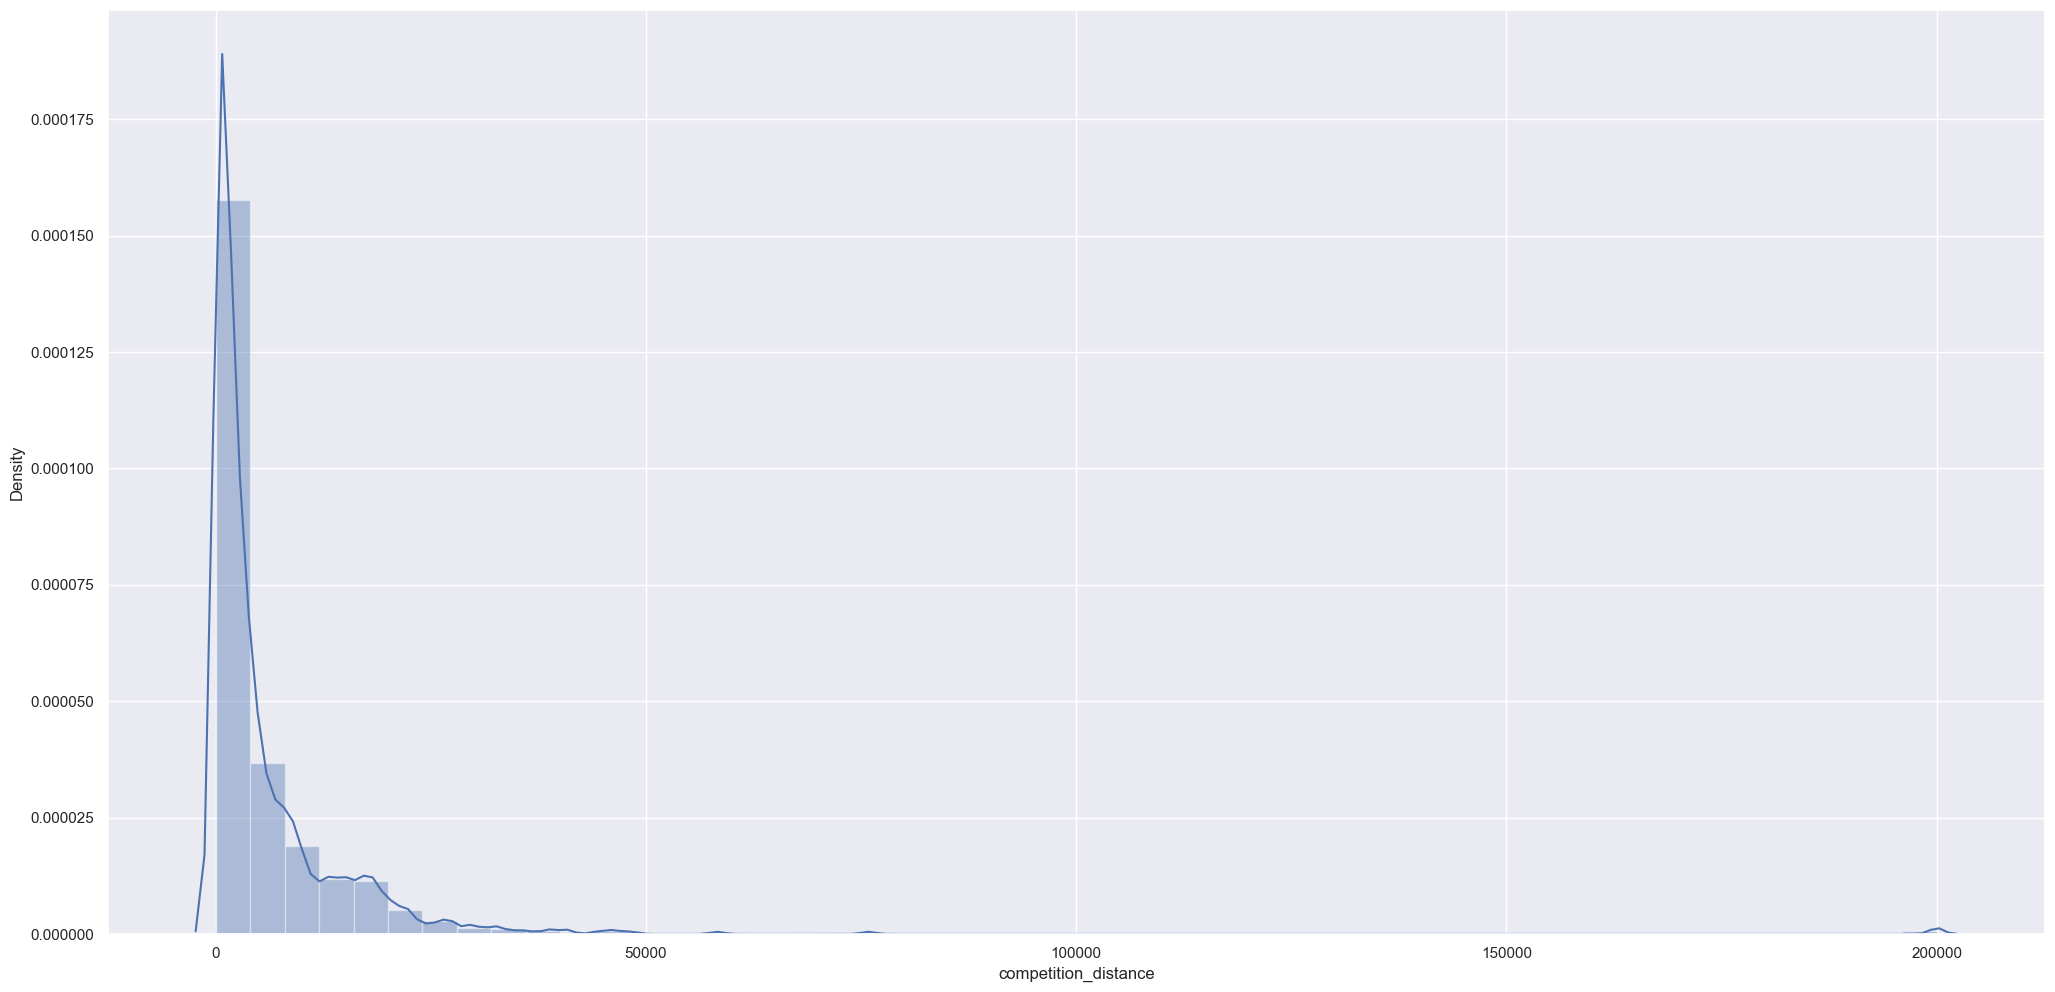

In [19]:
sns.distplot(df1['competition_distance'])

## 1.5 Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

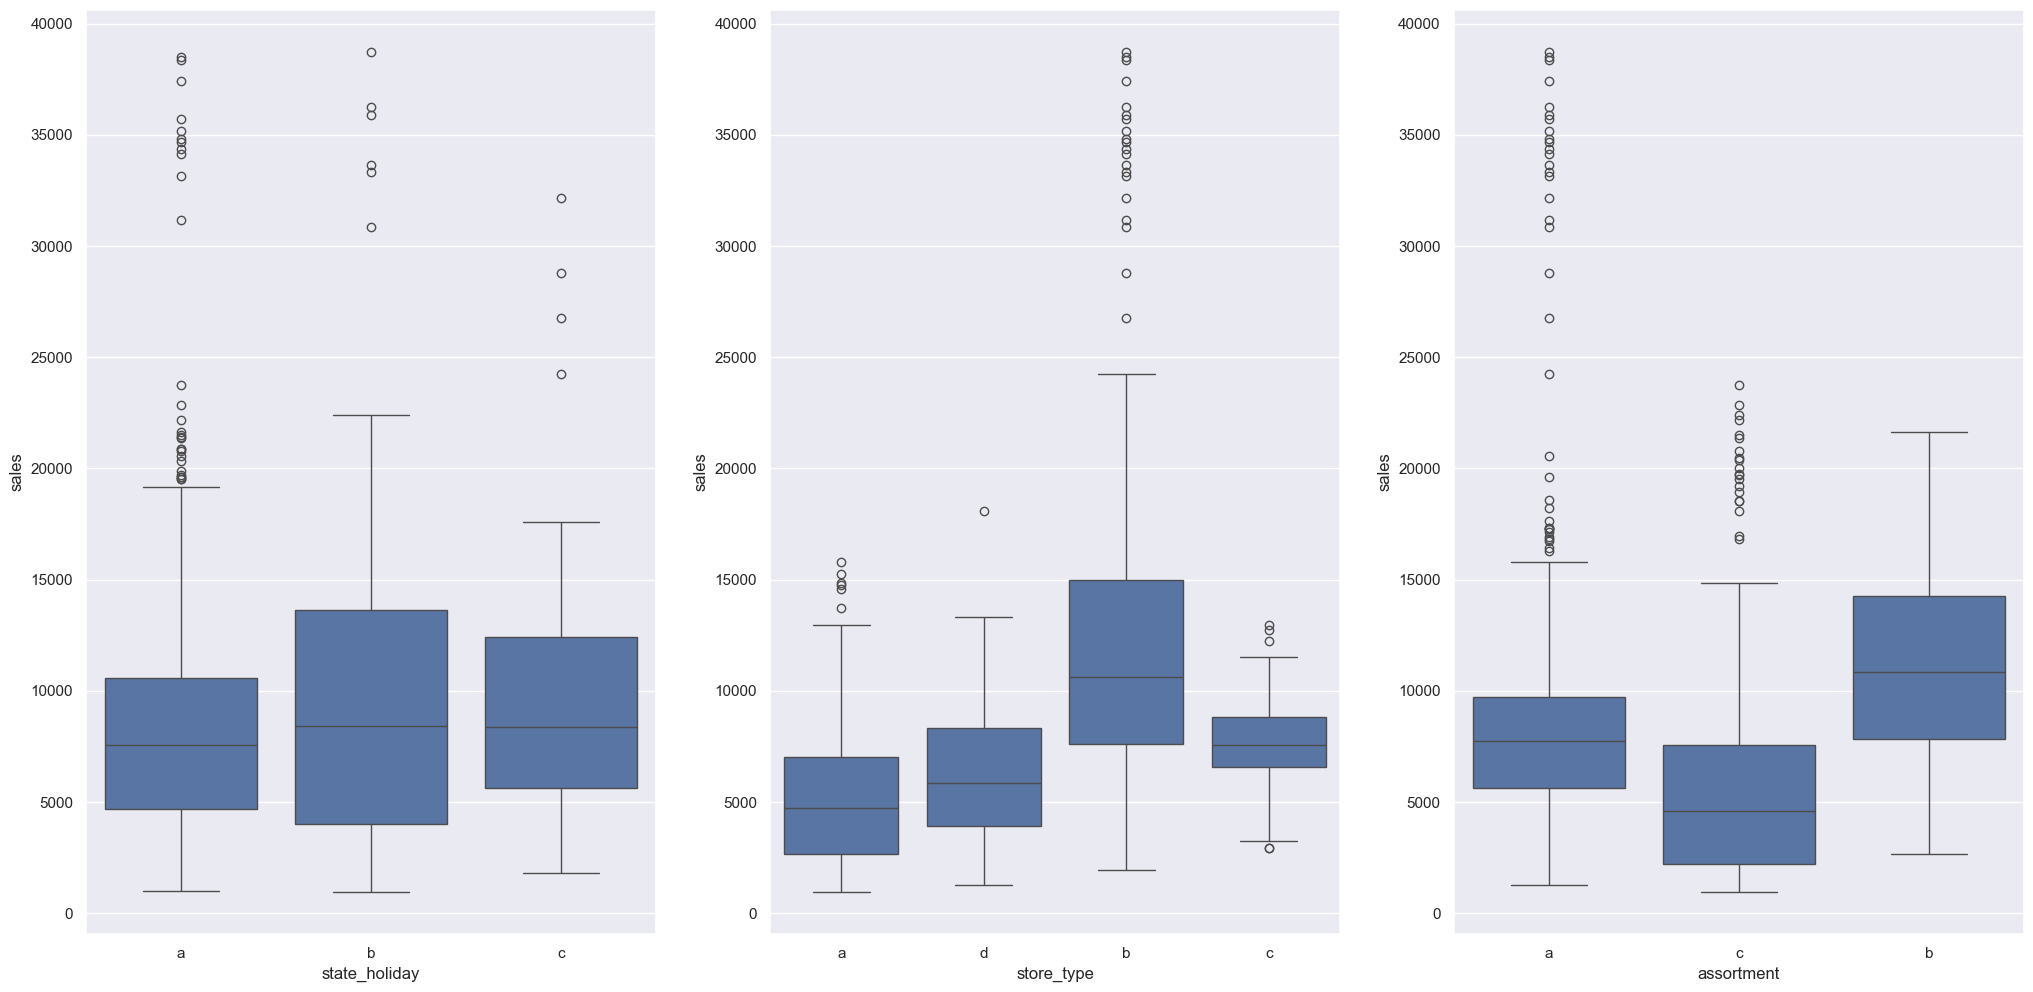

In [21]:
aux1 = df1[(df1['state_holiday']!= '0') & (df1['sales']> 0)]
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday' ,y='sales' ,data =aux1)
plt.subplot(1,3,2)
sns.boxplot(x='store_type' ,y='sales' ,data =aux1)
plt.subplot(1,3,3)
sns.boxplot(x='assortment' ,y='sales' ,data =aux1)

## 2.0 FEATURE ENGENEERING

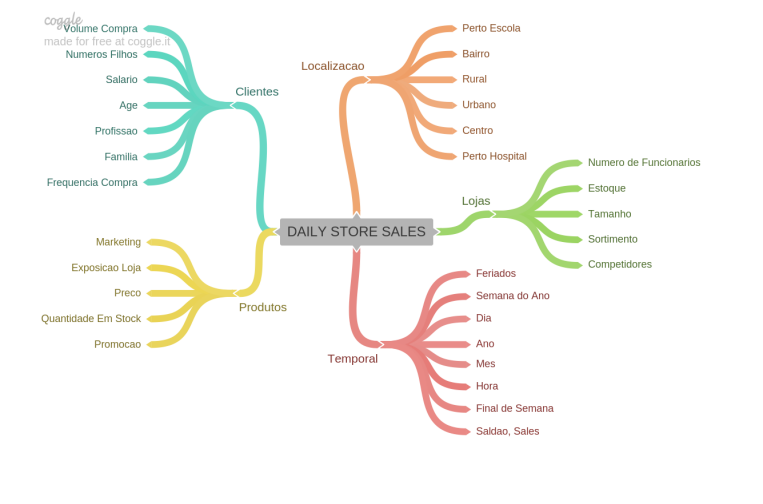

In [22]:
Image(r'fluxograma.png' )

## 2.1 Feature Engineering

In [23]:
df2 = df1.copy()

In [24]:
 # year
df2['year'] = df2['date'].dt.year
 # month
df2['month'] = df2['date'].dt.month
 # day
df2['day'] = df2['date'].dt.day
 # week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
 # year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
 # competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
 # promo since
df2['competition_time_month'] = ( ( df2['date']- df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' )- datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date']- df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else'extra' if x == 'b' else 'extended' )
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday'if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c'else 'regular_day' )


df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Variable Filtering

In [25]:
df3 = df2.copy()

## 3.1 Rows Selection

In [26]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [28]:
cols_drop=['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis = 1)

## 4.0 Exploratory Data Analysis

In [29]:
df4 = df3.copy()

## 4.1 Univariate analysis

### 4.1.1 Response Variable

C:\Users\israb\AppData\Local\Temp\ipykernel_19684\1473926699.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'])


<Axes: xlabel='sales', ylabel='Density'>

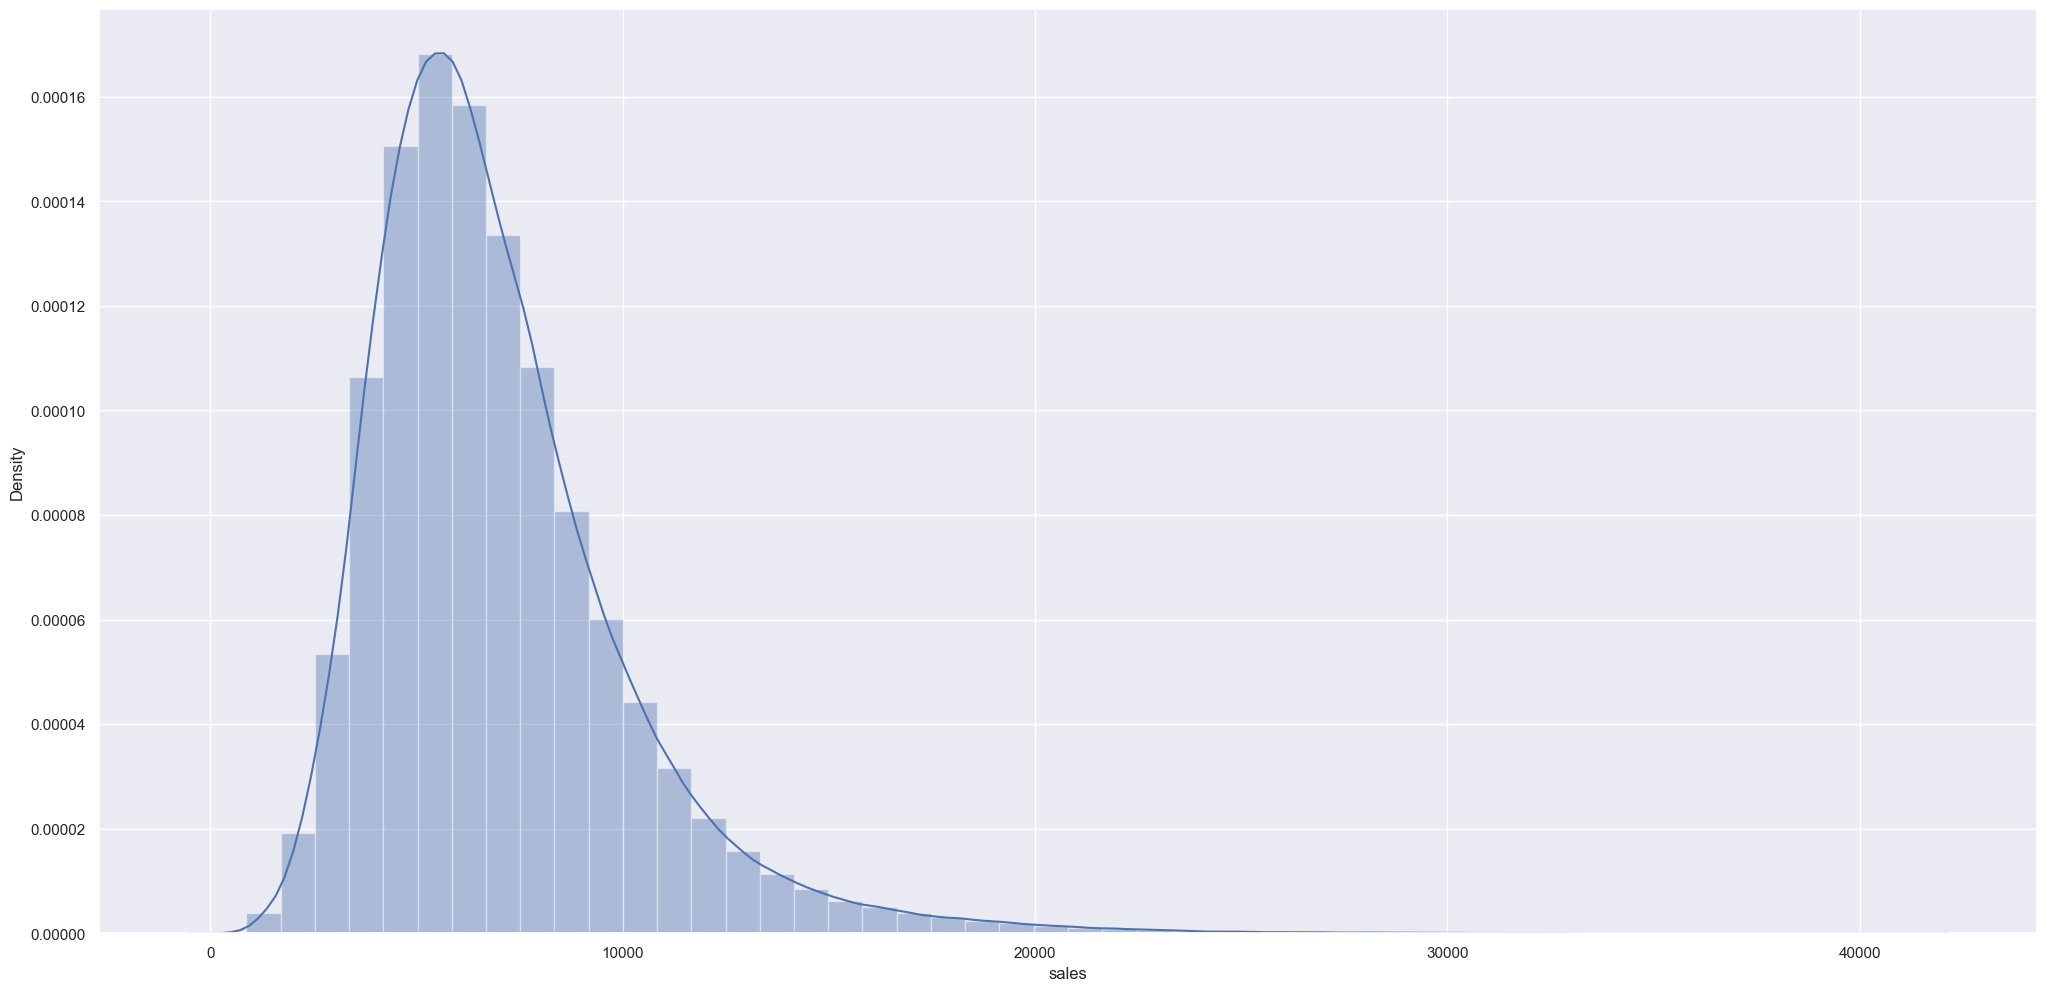

In [30]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical Variable

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

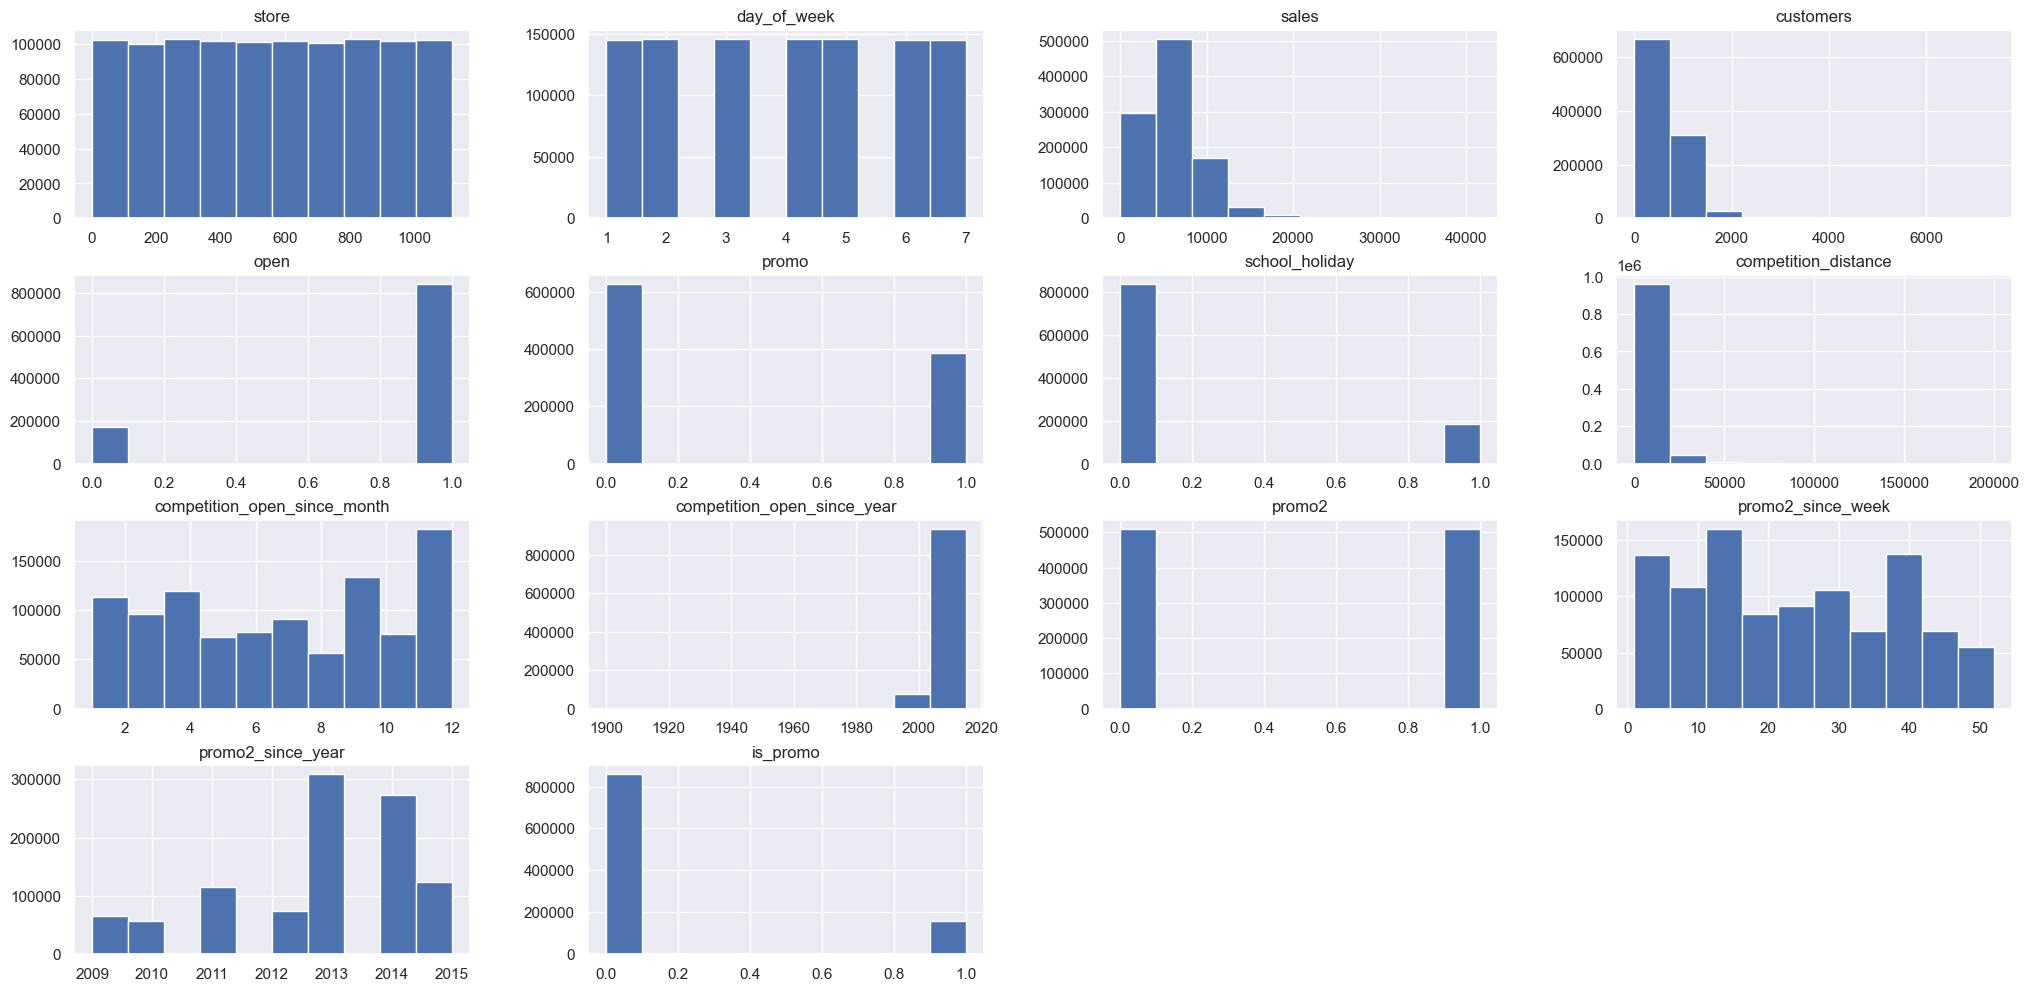

In [31]:
num_attributes.hist()
# variáveis que não mexem muito provavelmente não tem mto impacto na variável resposta

### 4.1.3 Categorical Variable

In [32]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

C:\Users\israb\AppData\Local\Temp\ipykernel_19684\1131753916.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', shade=True )
C:\Users\israb\AppData\Local\Temp\ipykernel_19684\1131753916.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday', shade=True )
C:\Users\israb\AppData\Local\Temp\ipykernel_19684\1131753916.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', shade=True )
C:\Users\israb\AppDa

<Axes: xlabel='sales', ylabel='Density'>

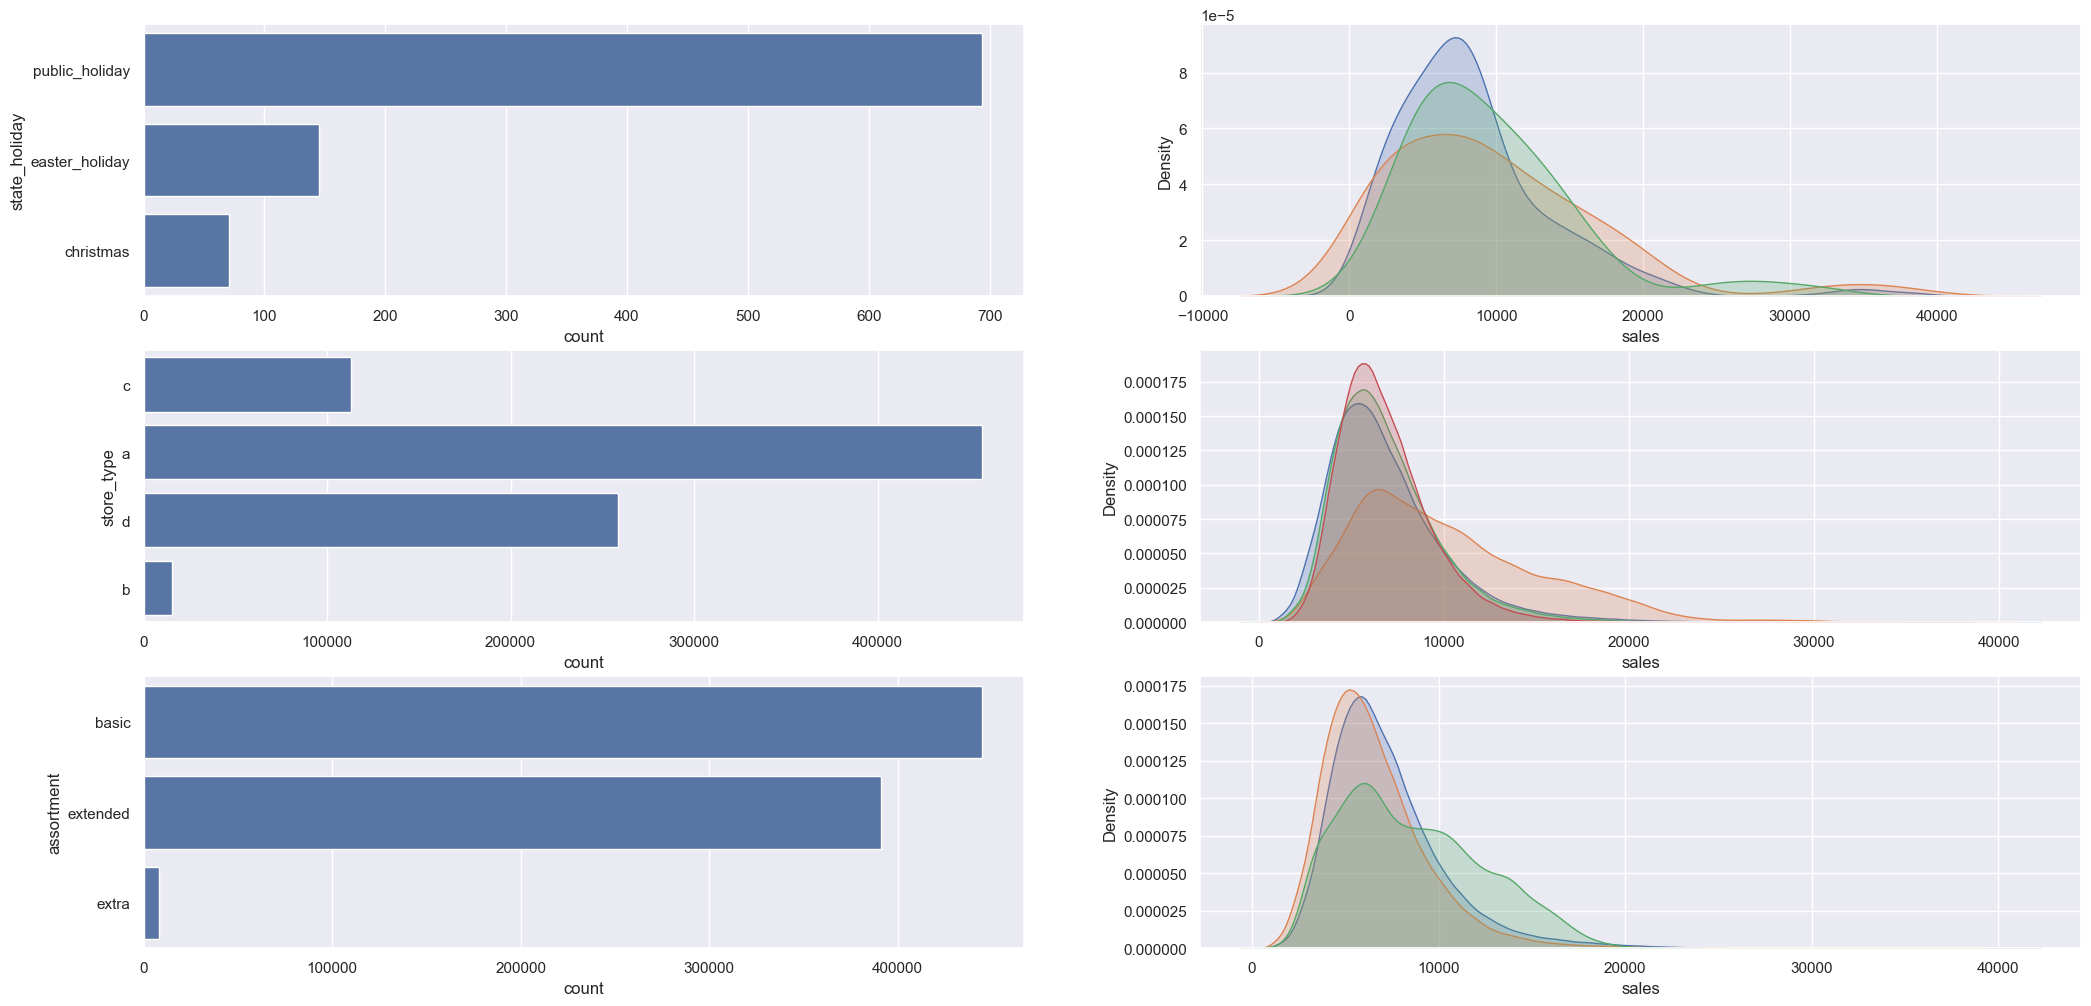

In [33]:
 # state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', shade=True )
# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True )


## 4.2 Bivariate analysis

<Axes: xlabel='year_week'>

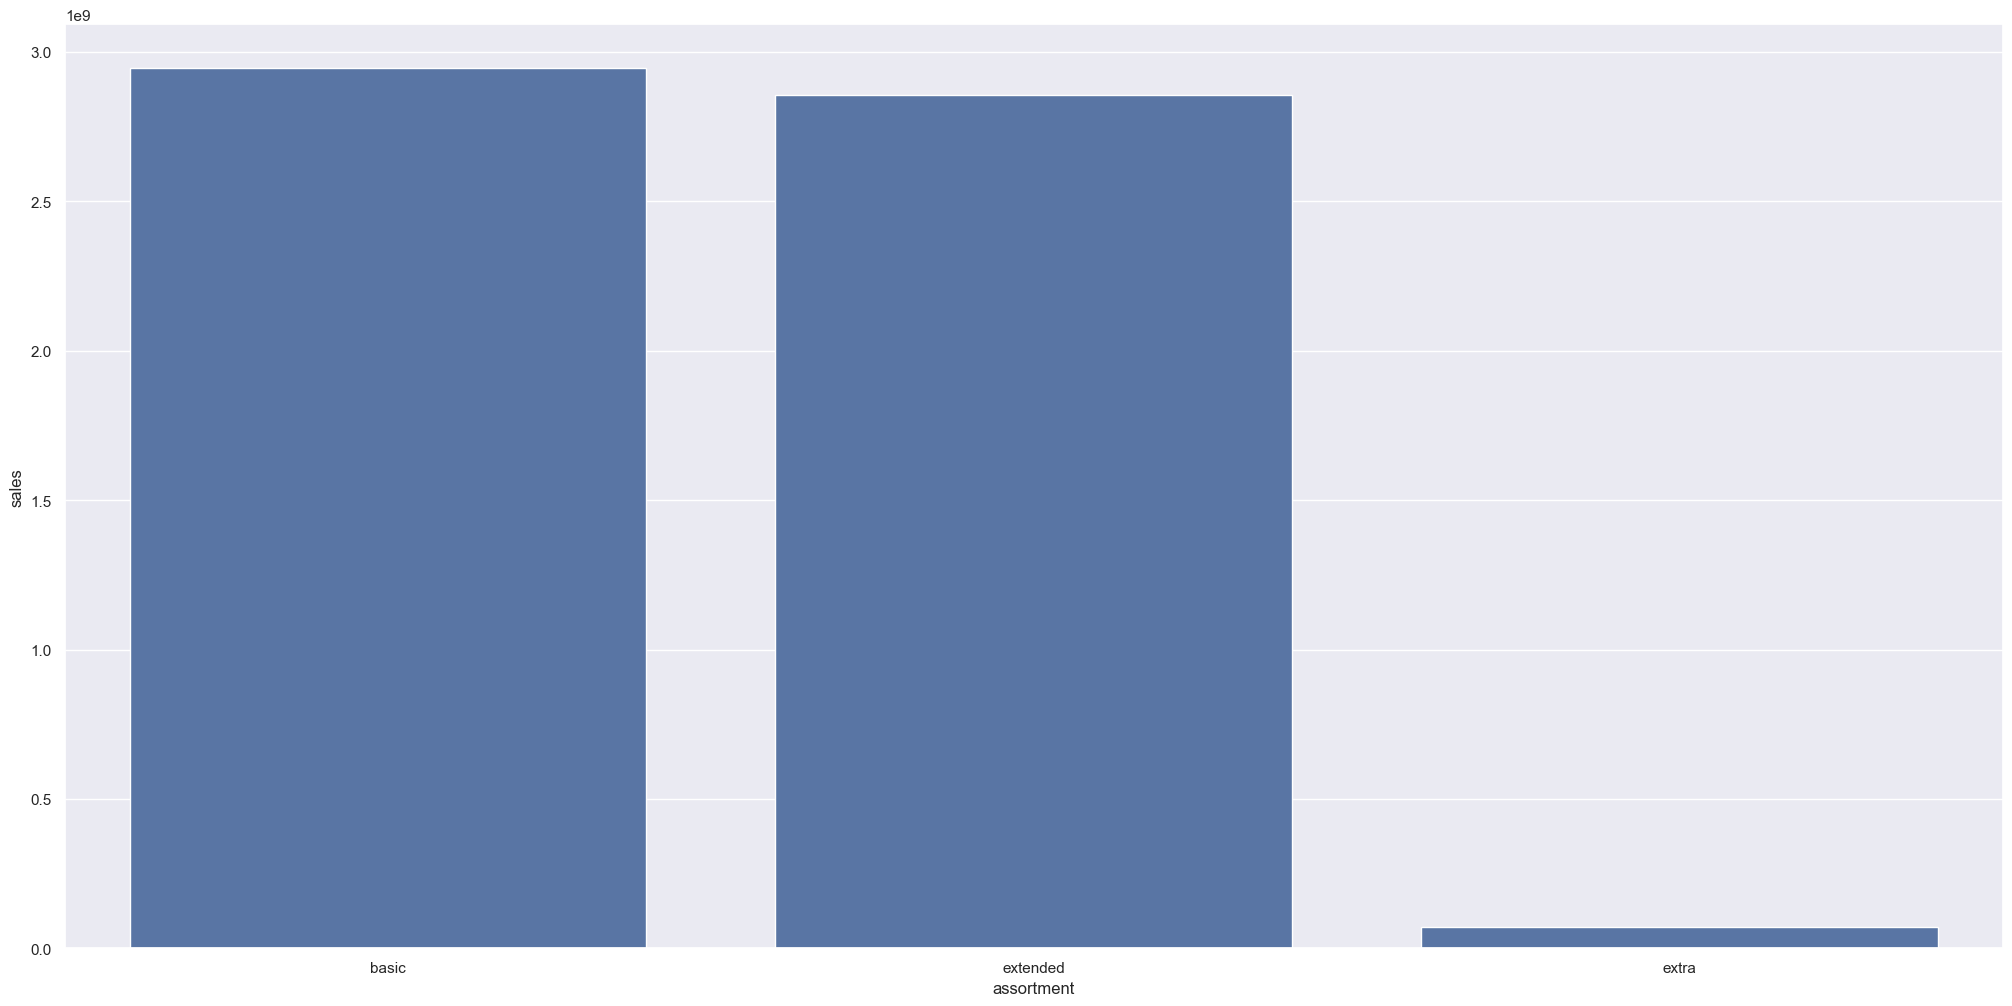

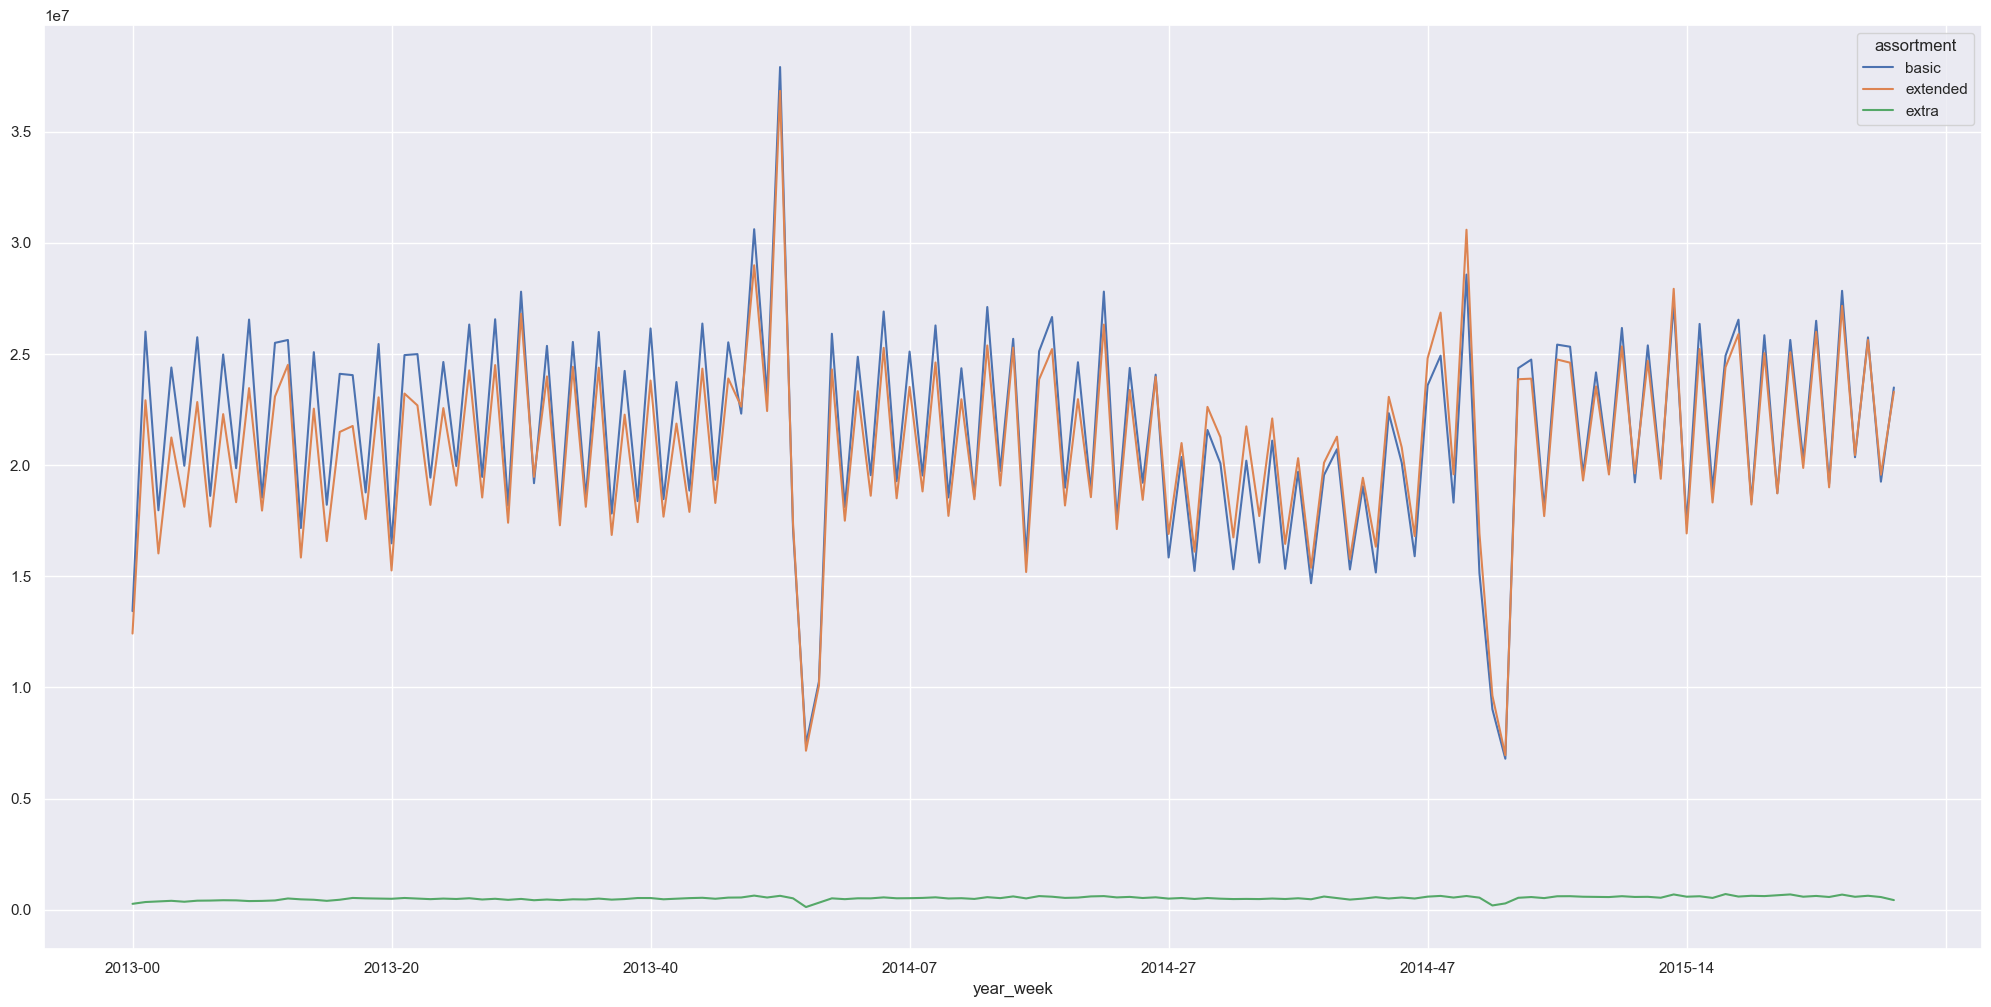

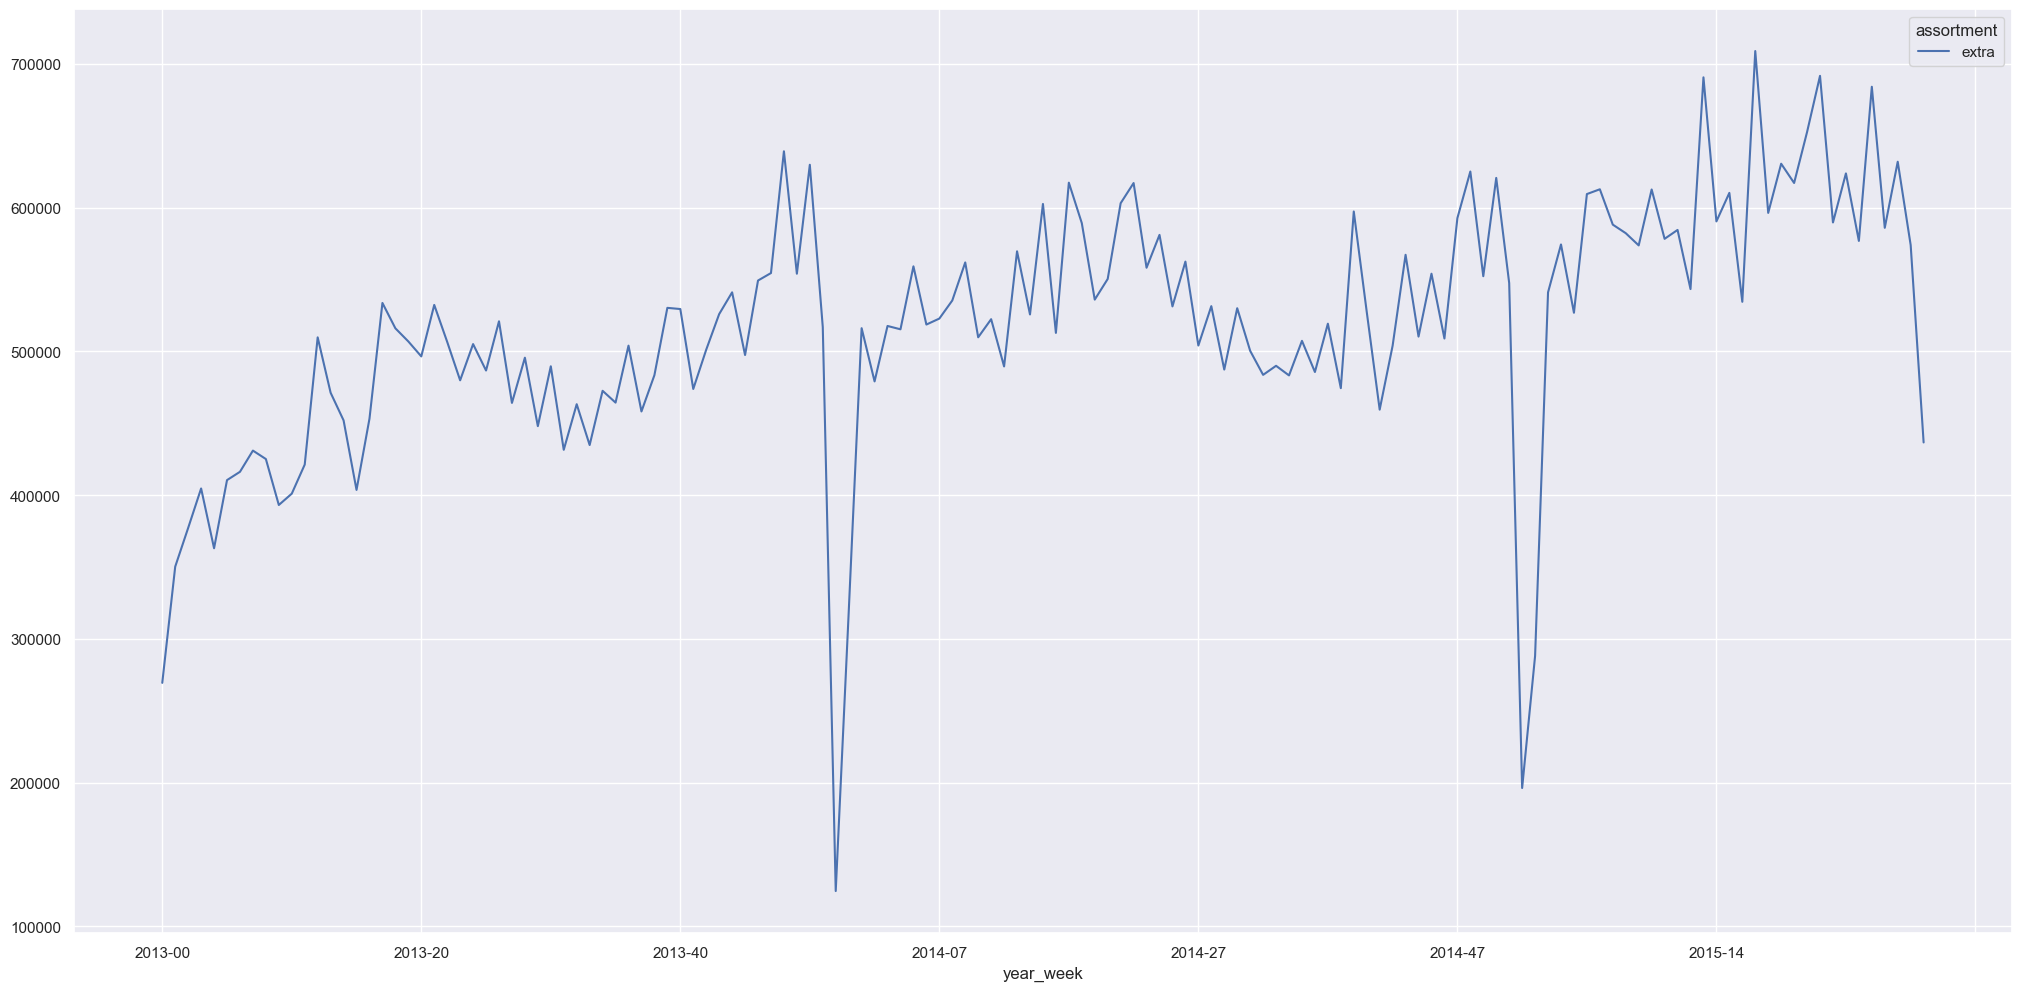

In [34]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

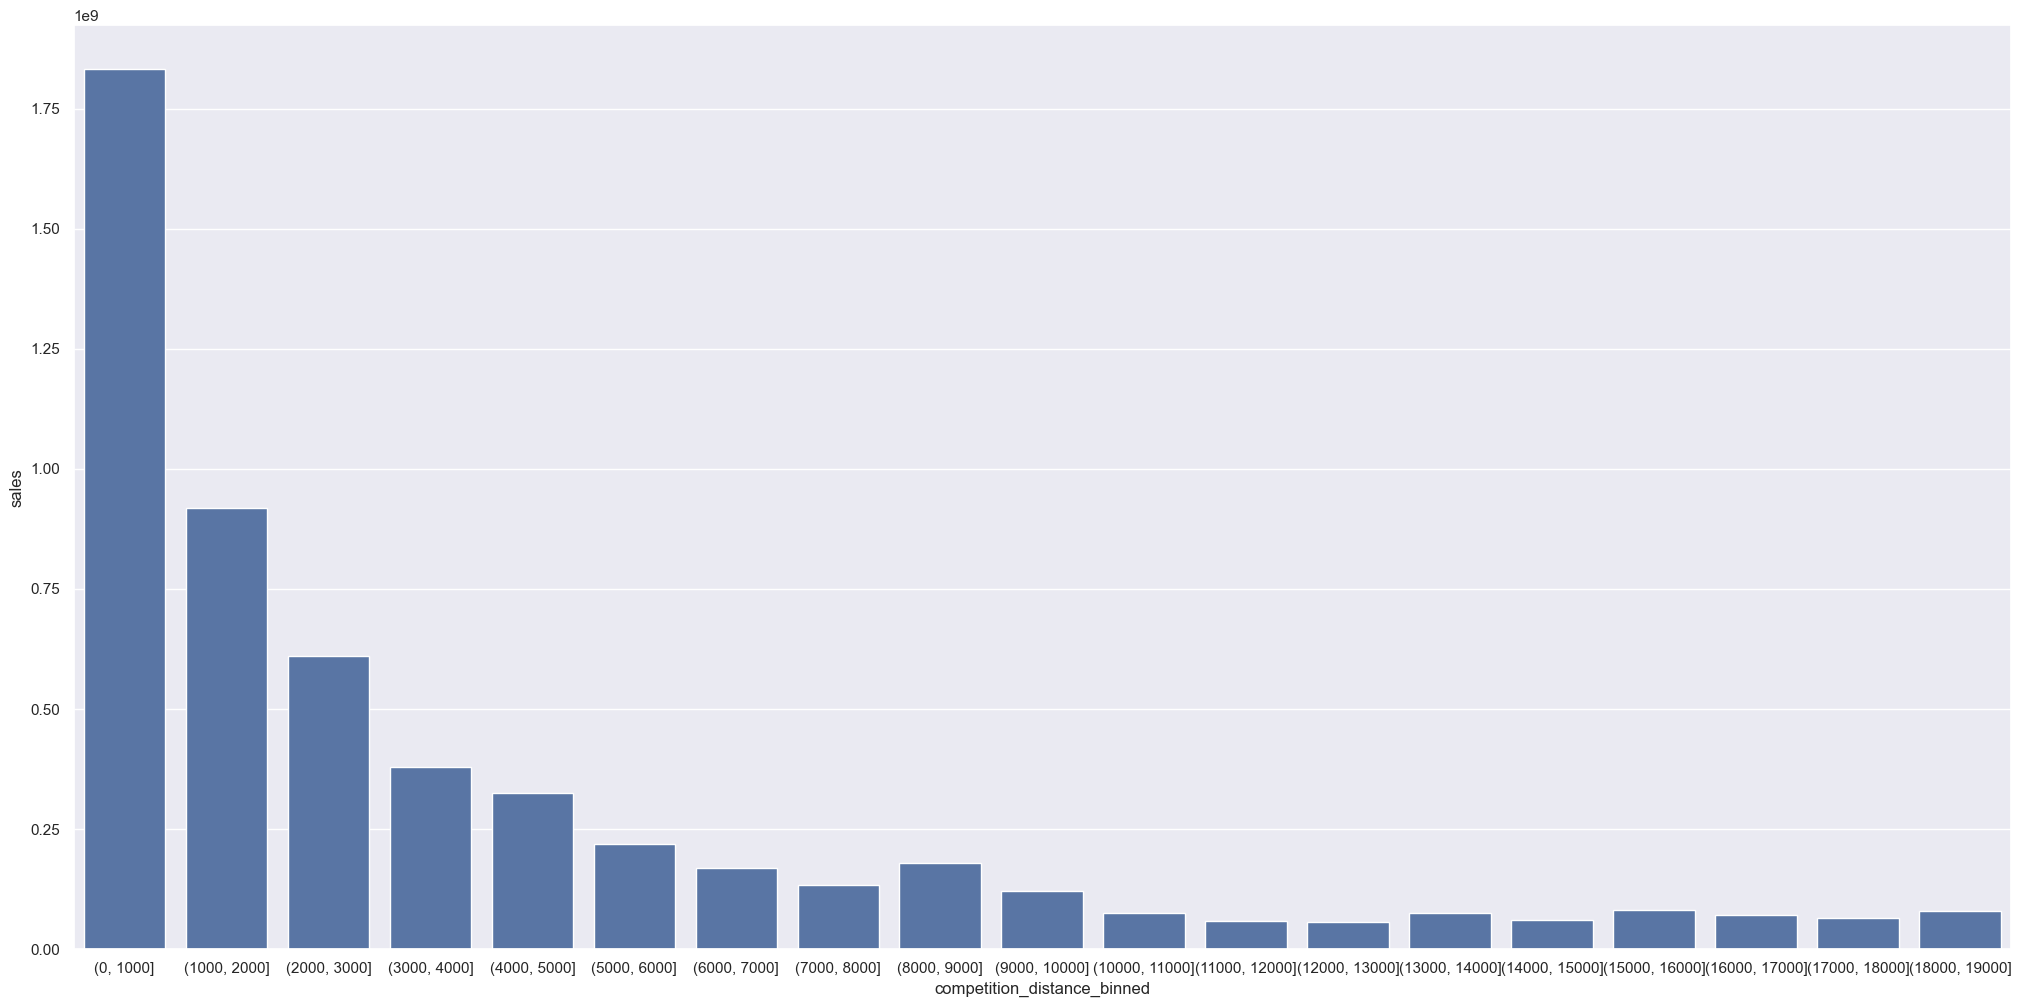

In [35]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned']=pd.cut(aux1['competition_distance'],bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );

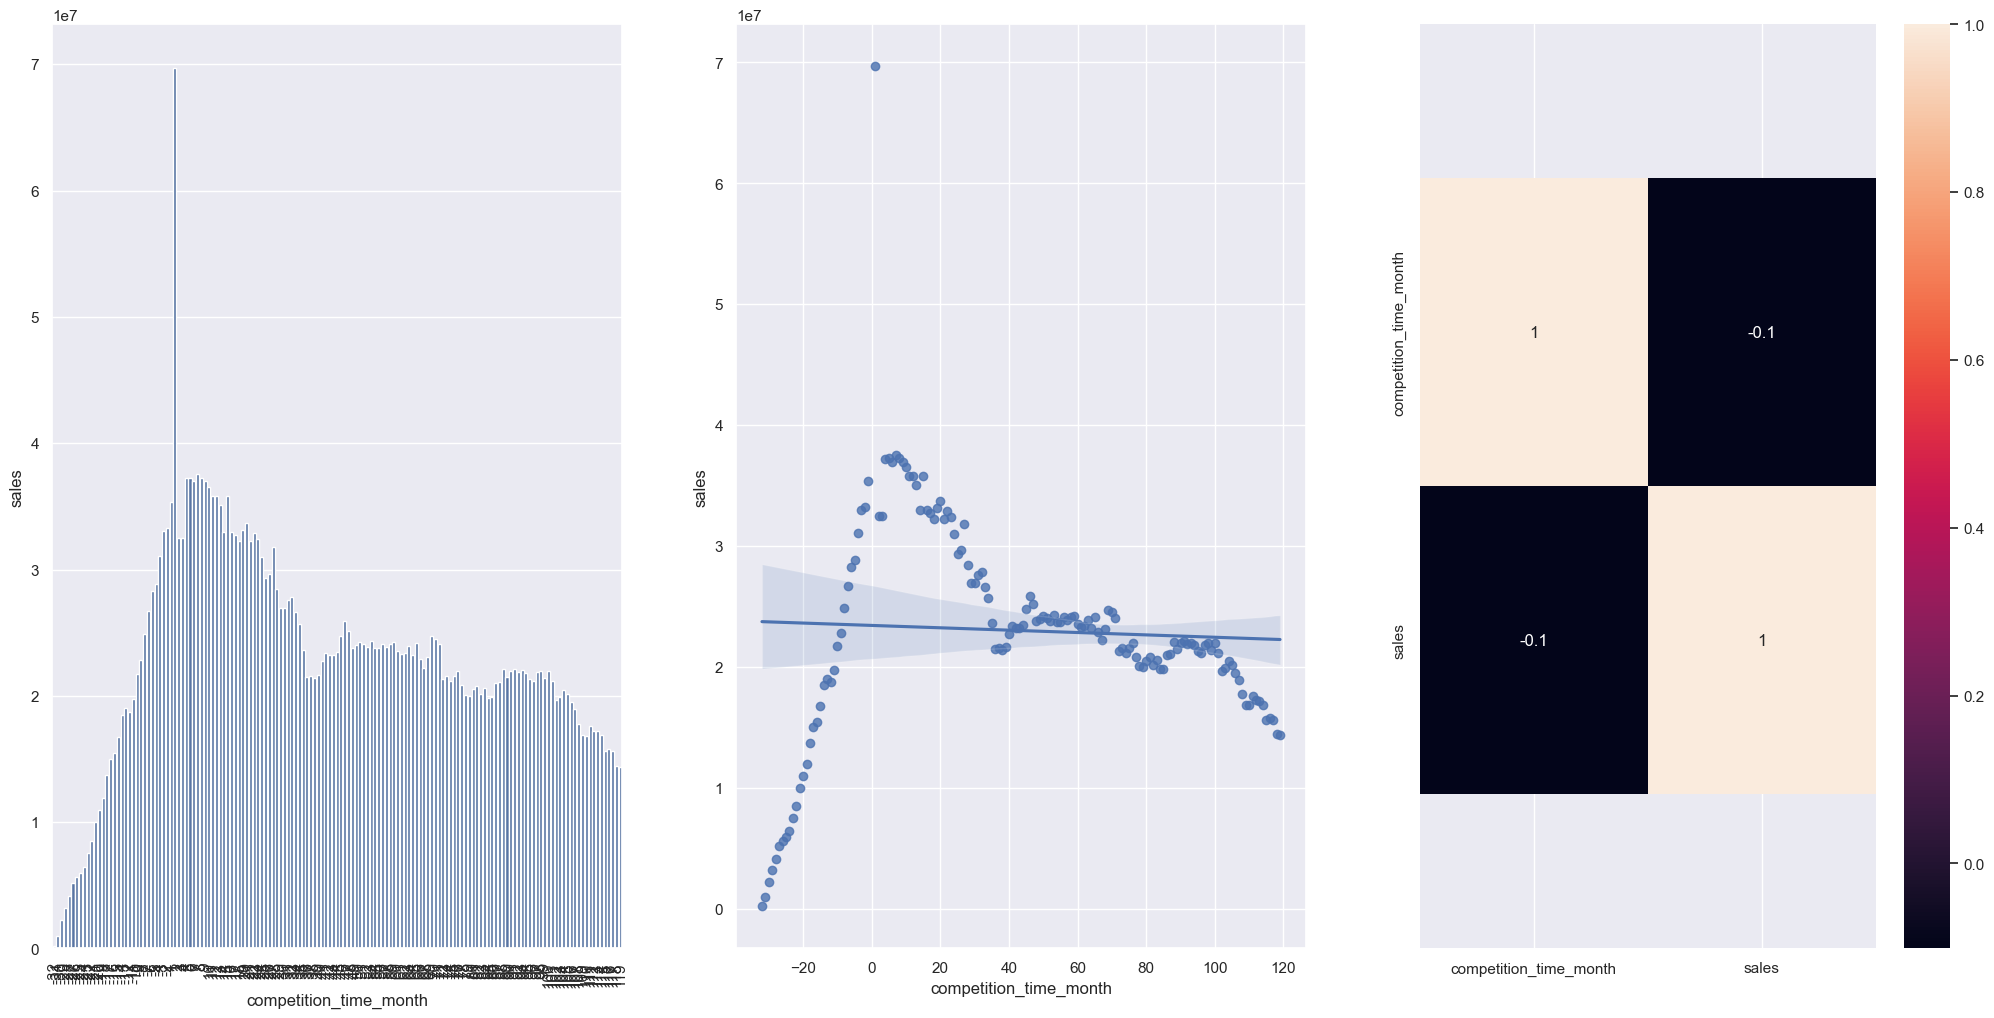

In [36]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

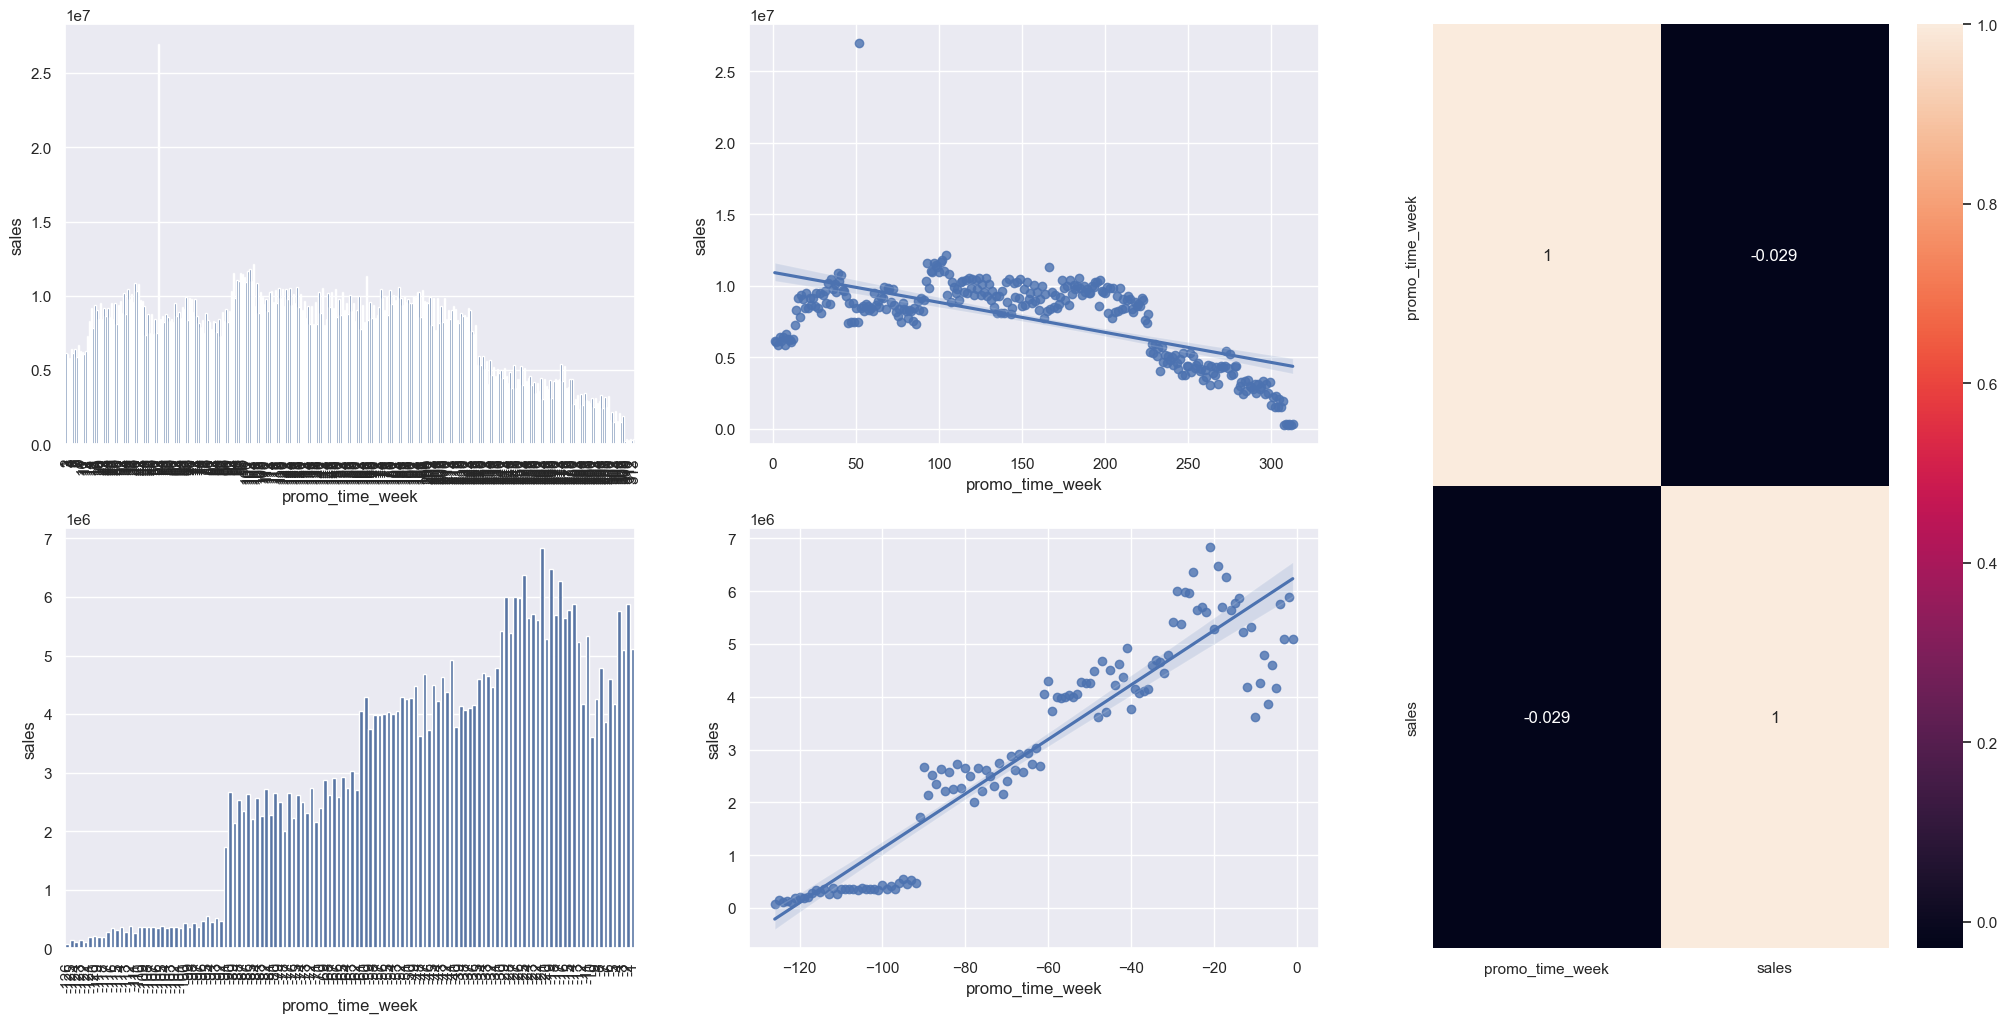

In [37]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
grid = GridSpec( 2, 3 )
plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );
plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );
plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );
plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

In [38]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


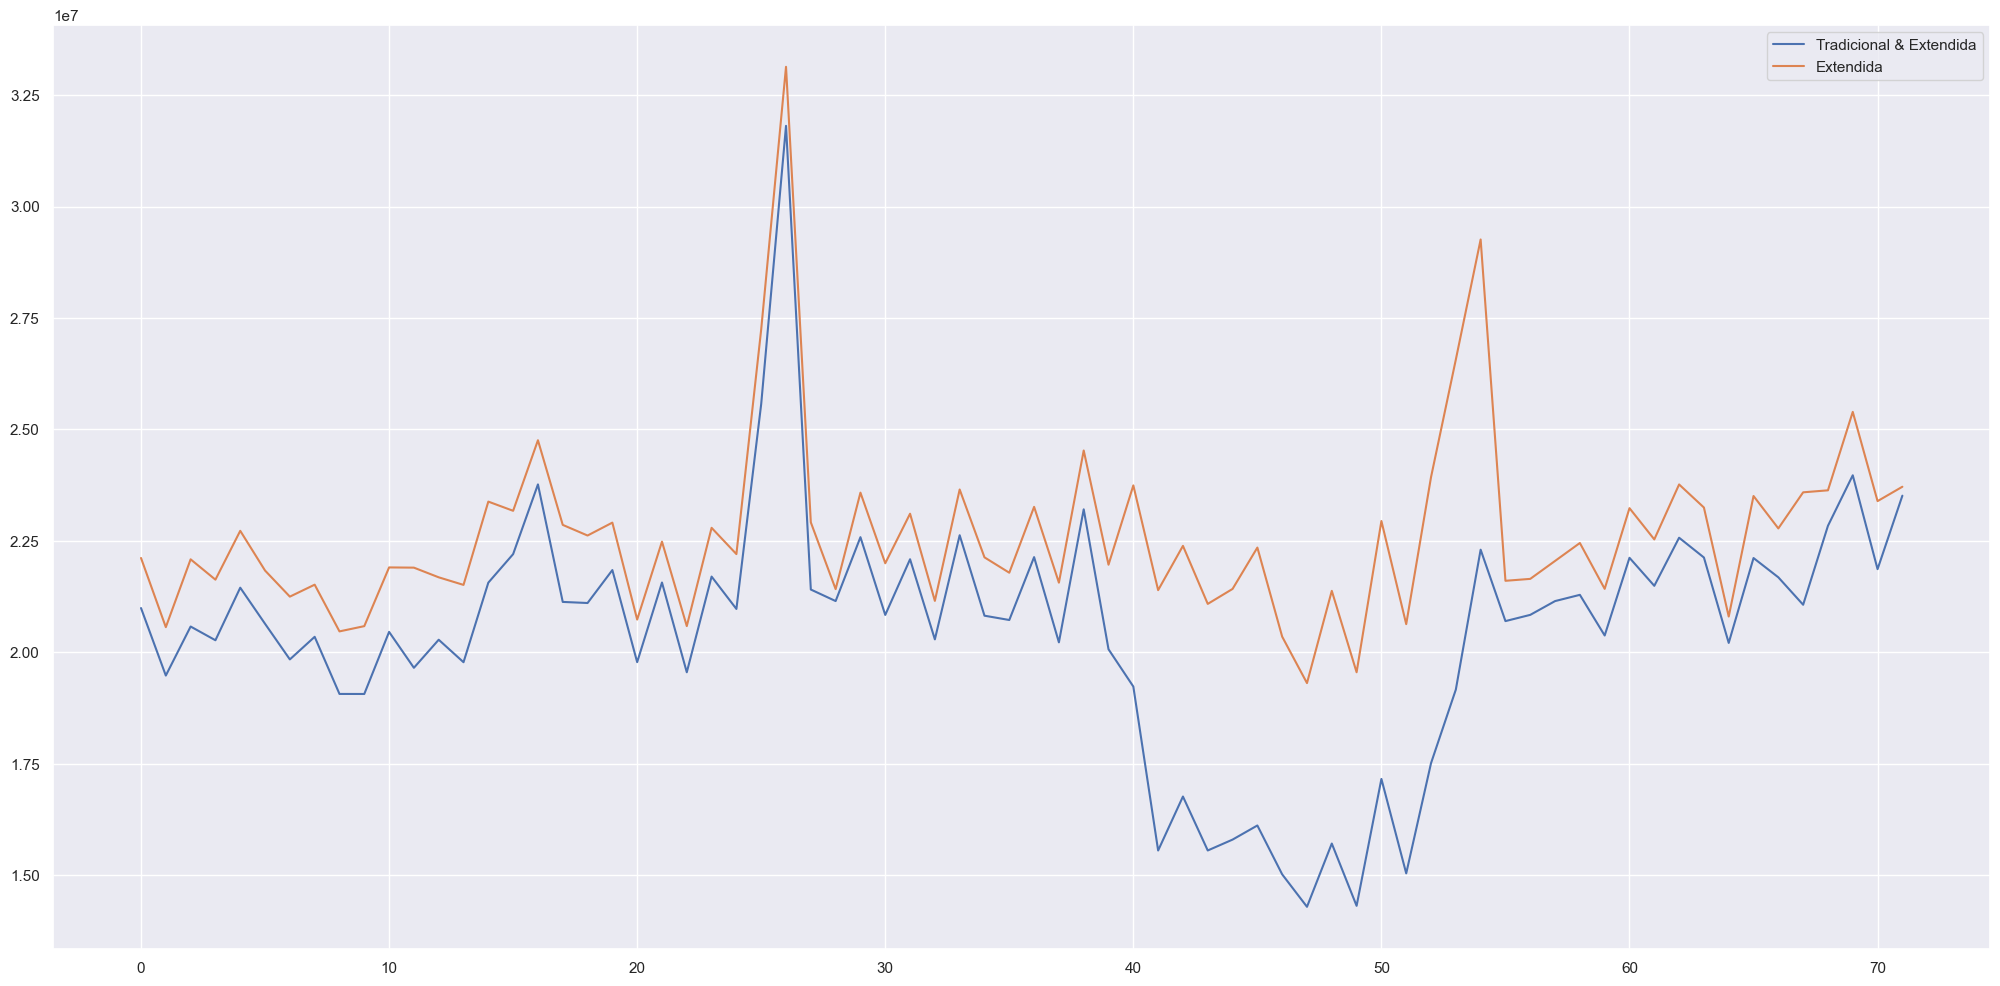

In [39]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

<Axes: xlabel='state_holiday', ylabel='sales'>

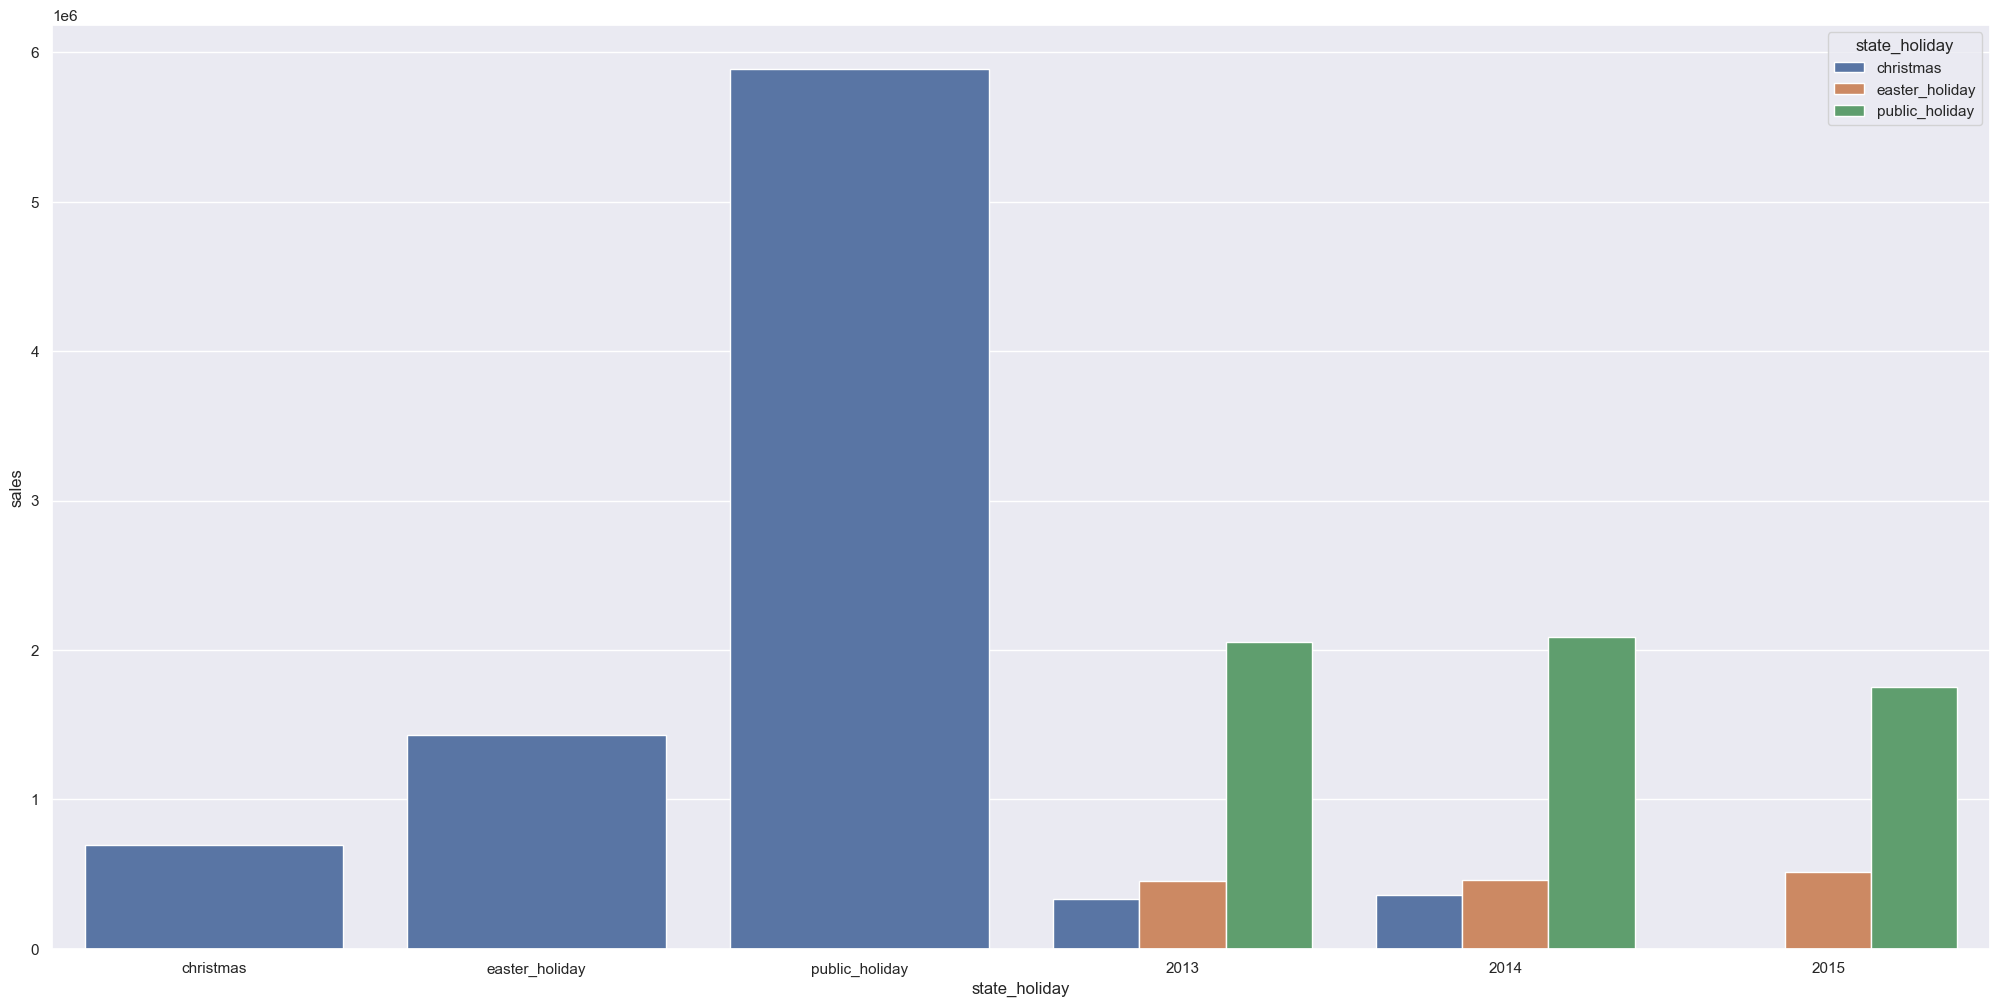

In [40]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data=aux1)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2)

C:\Users\israb\AppData\Local\Temp\ipykernel_19684\1856027667.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'),annot = True)


<Axes: >

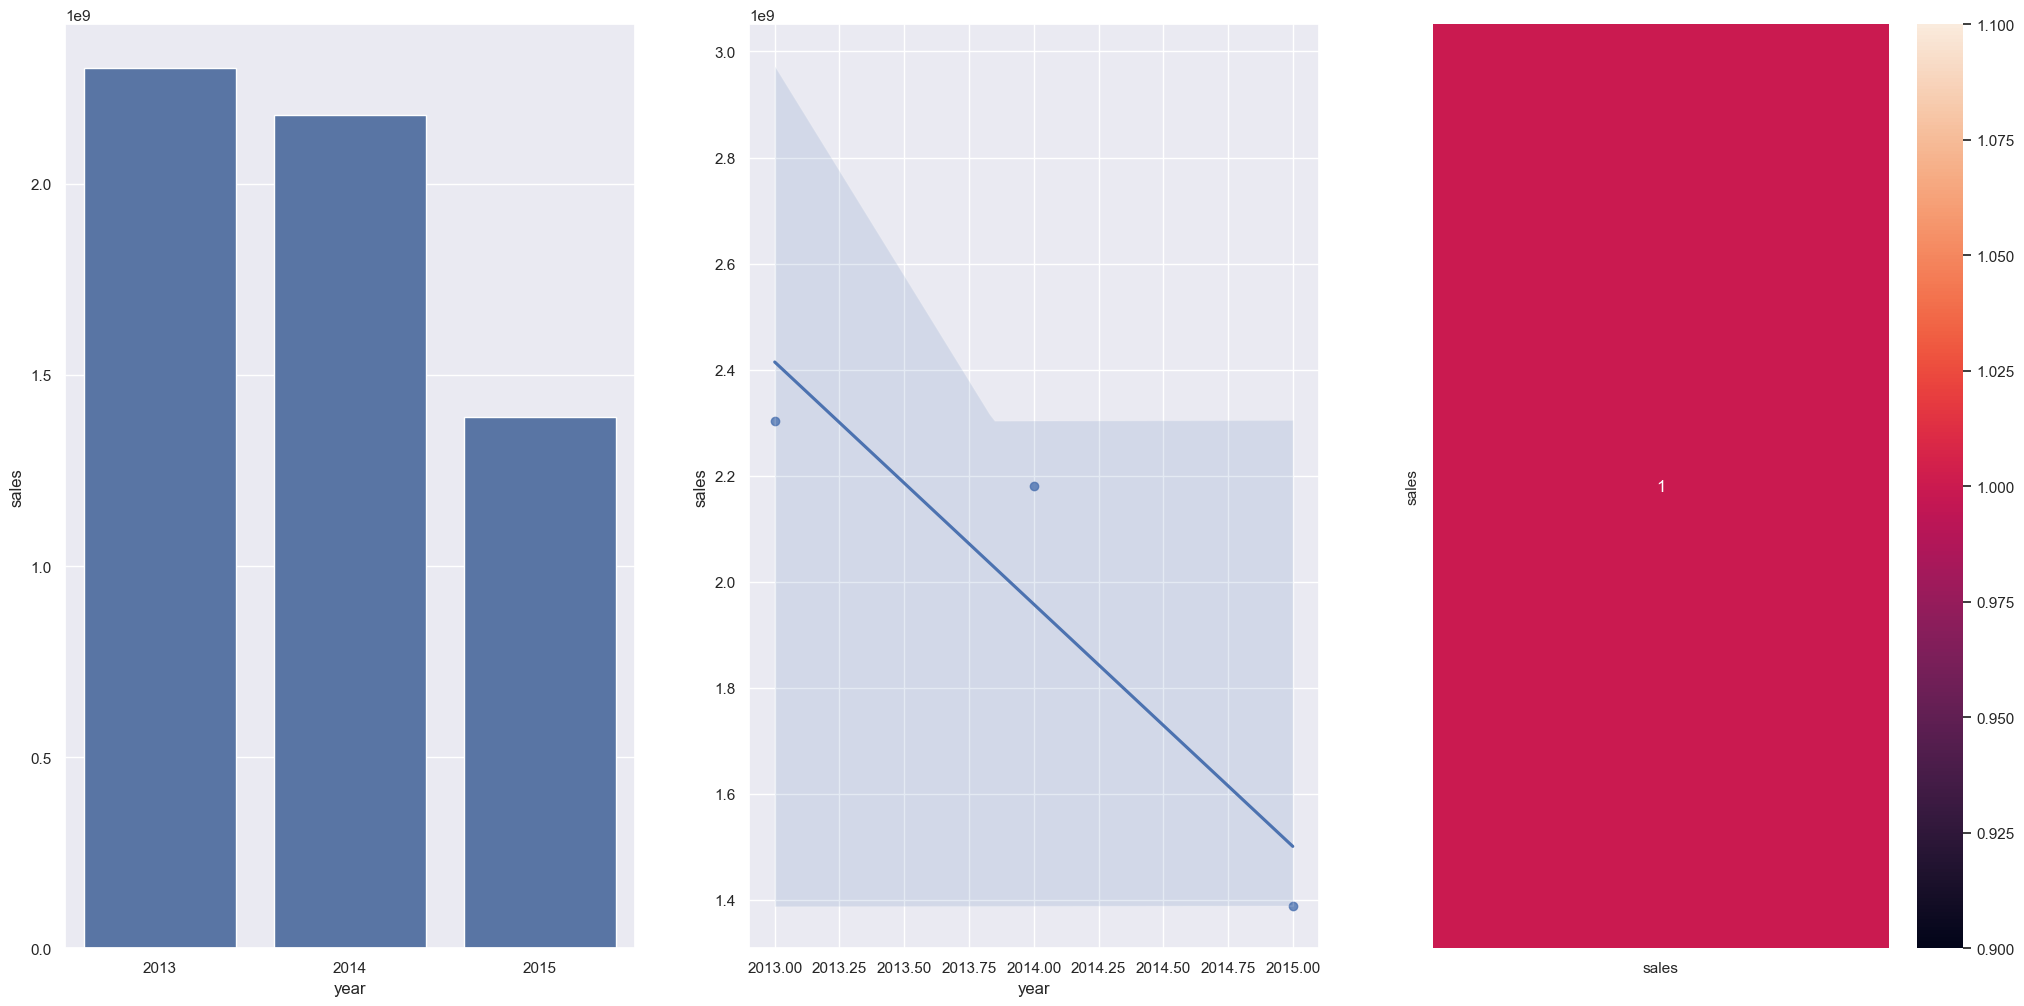

In [41]:
aux = df4[['year','sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux)
plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot = True)

C:\Users\israb\AppData\Local\Temp\ipykernel_19684\2833546014.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'),annot = True)


<Axes: >

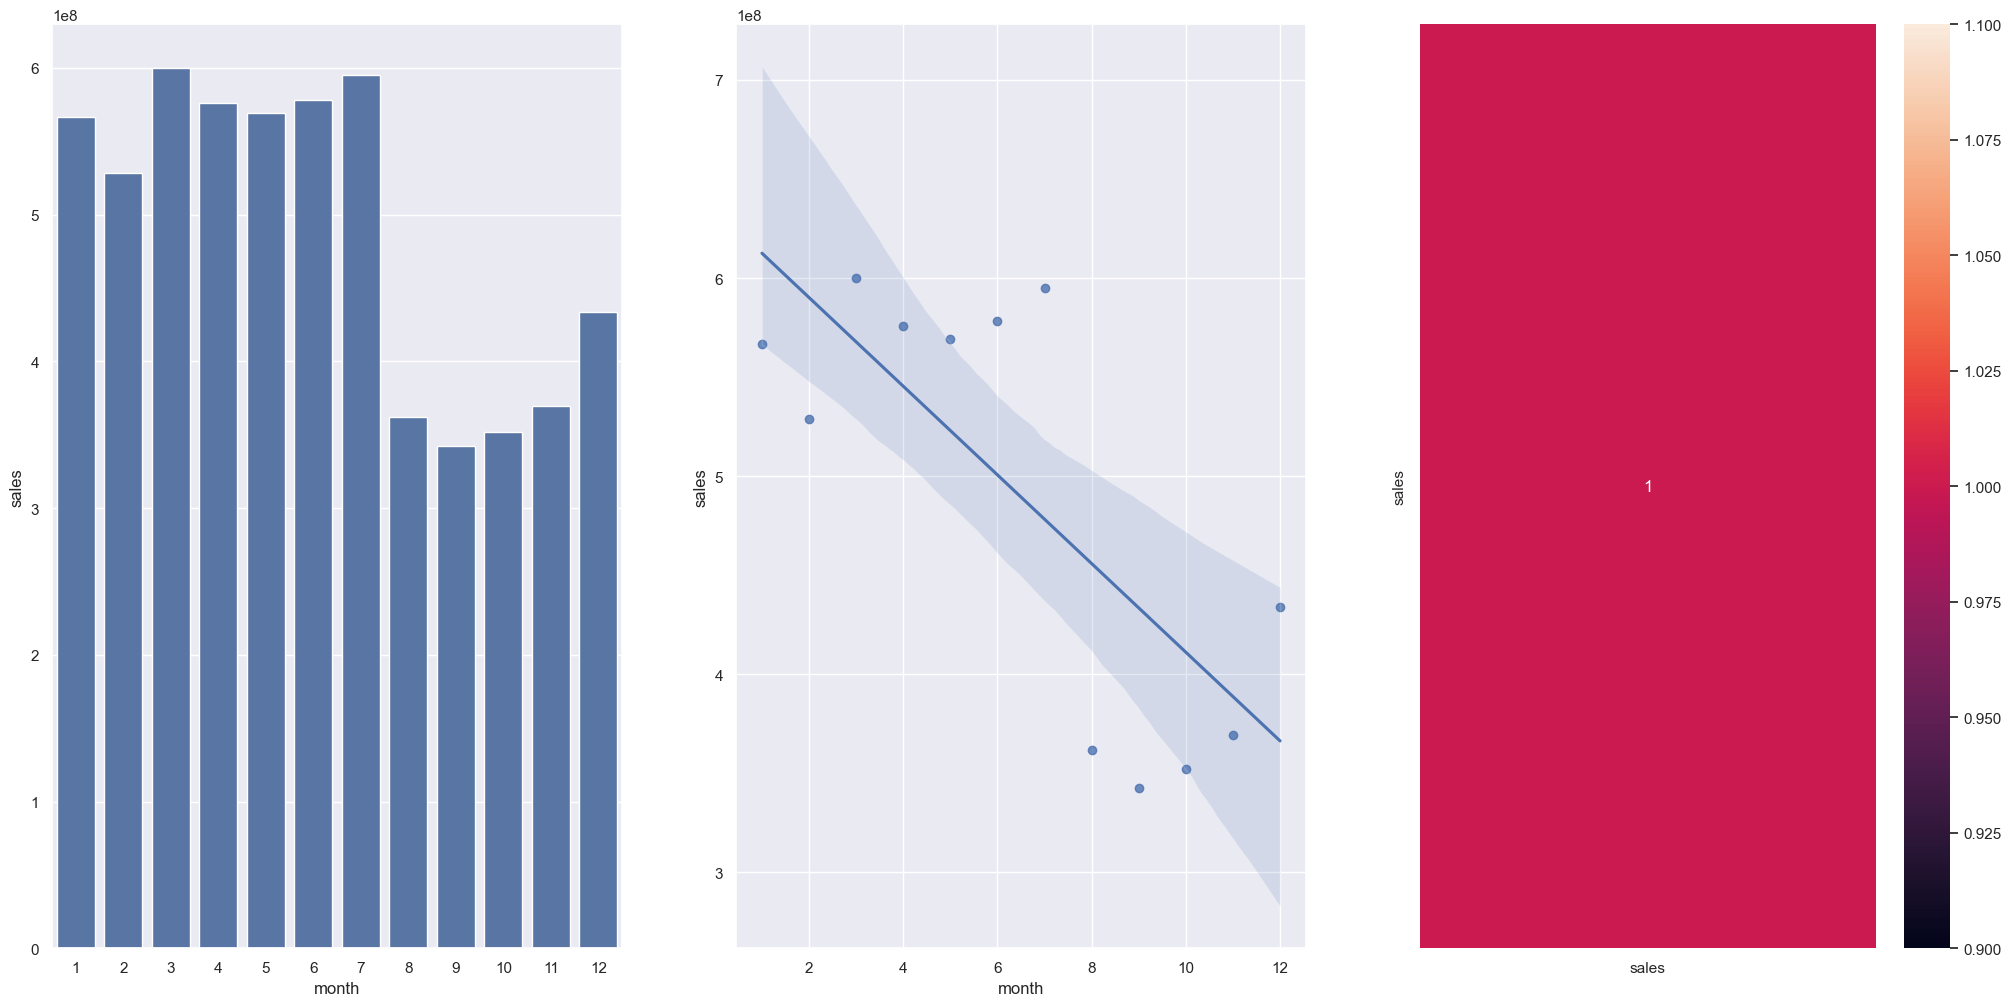

In [42]:
aux = df4[['month','sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux)
plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot = True)

C:\Users\israb\AppData\Local\Temp\ipykernel_19684\4272359662.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'),annot = True)


<Axes: xlabel='before_after', ylabel='sales'>

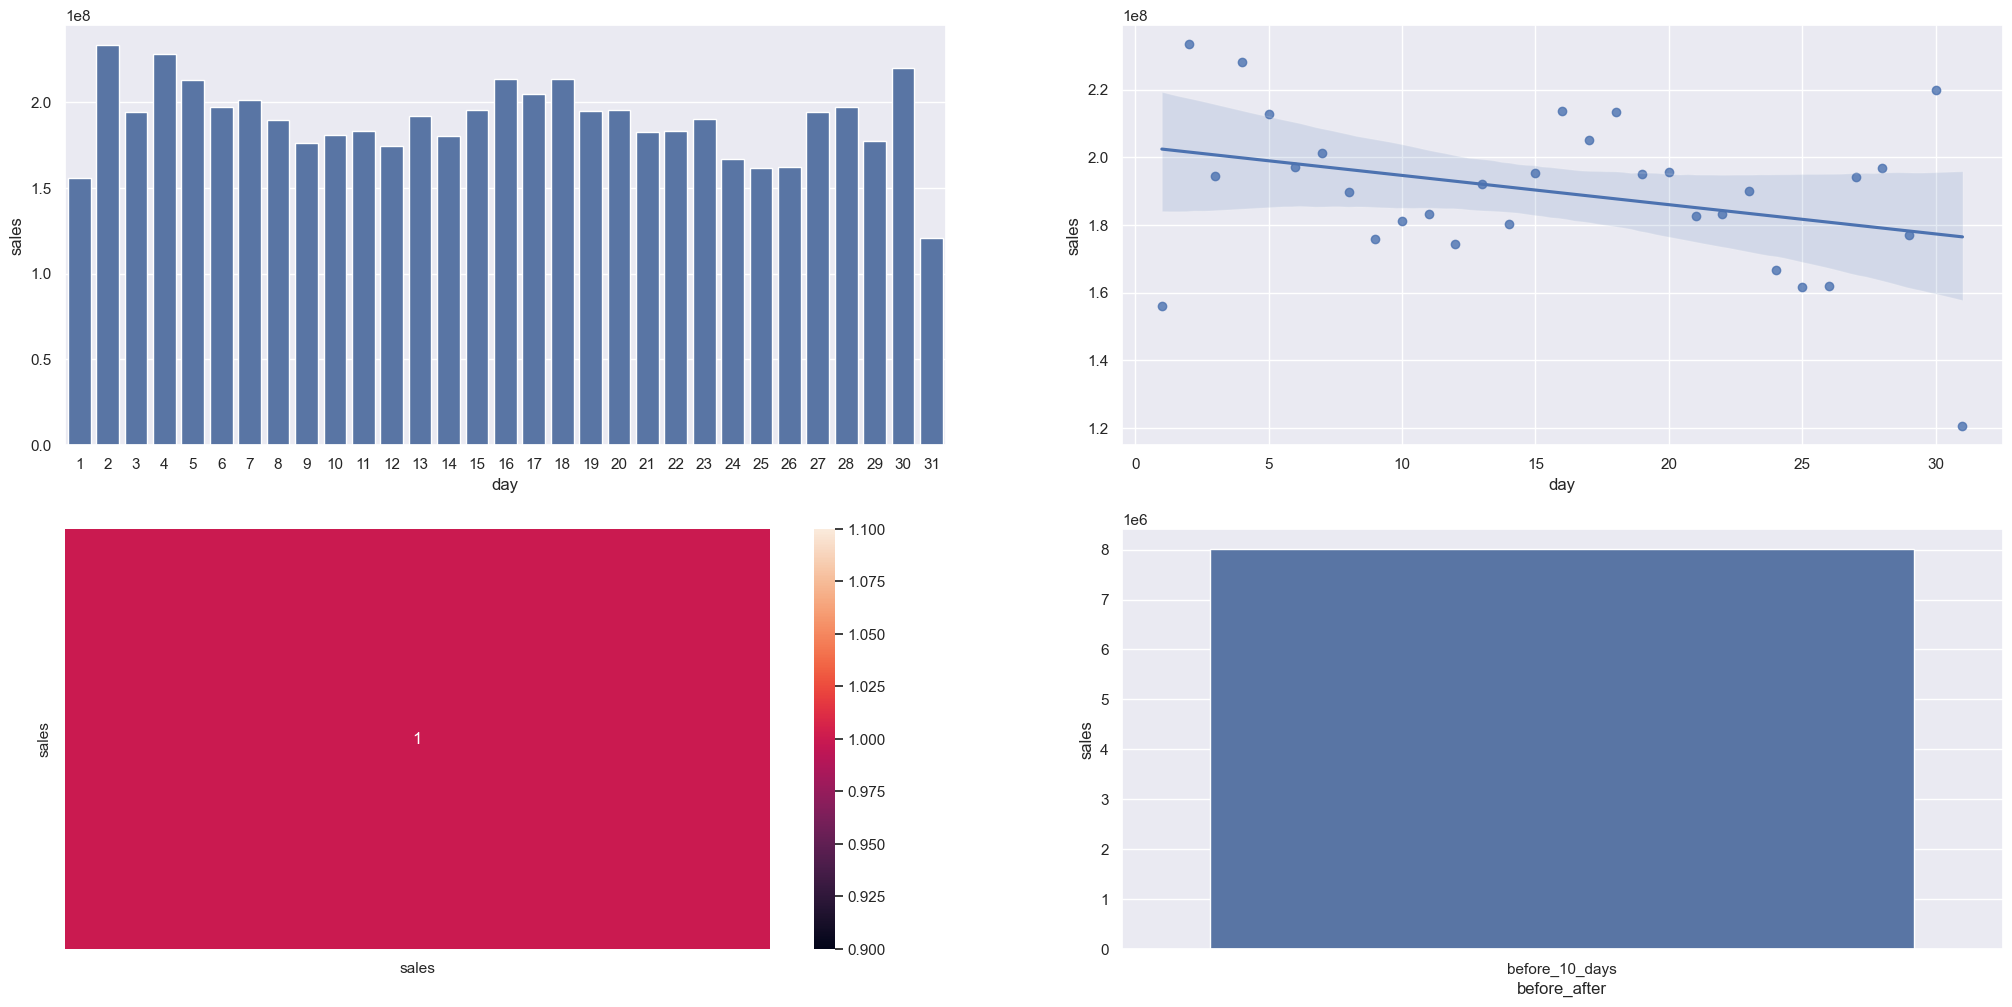

In [43]:
aux = df4[['day','sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux)
plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux)
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot = True)

aux1['before_after']=aux['day'].apply(lambda x:'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux2)

C:\Users\israb\AppData\Local\Temp\ipykernel_19684\1747502636.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'),annot = True)


<Axes: >

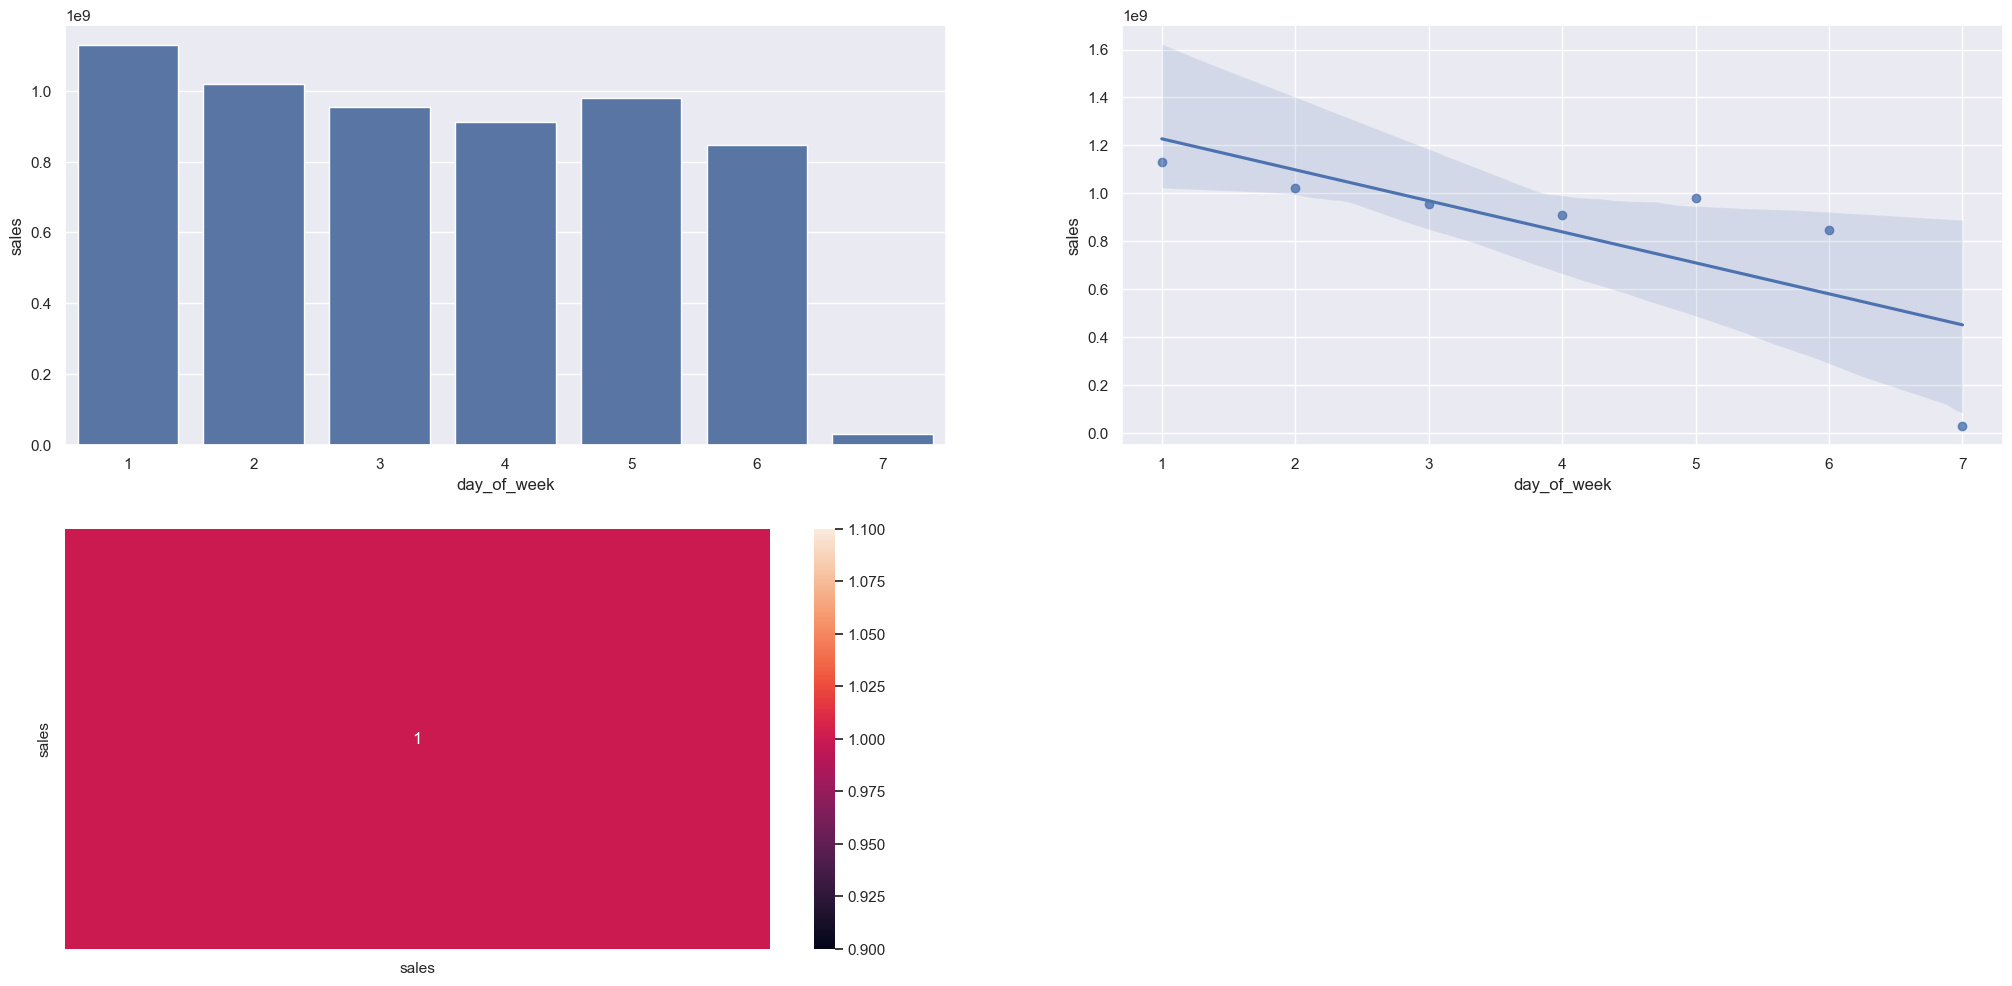

In [44]:
aux = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day_of_week',y='sales',data=aux)
plt.subplot(2,2,2)
sns.regplot(x='day_of_week',y='sales',data=aux)
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot = True)


<Axes: xlabel='school_holiday', ylabel='sales'>

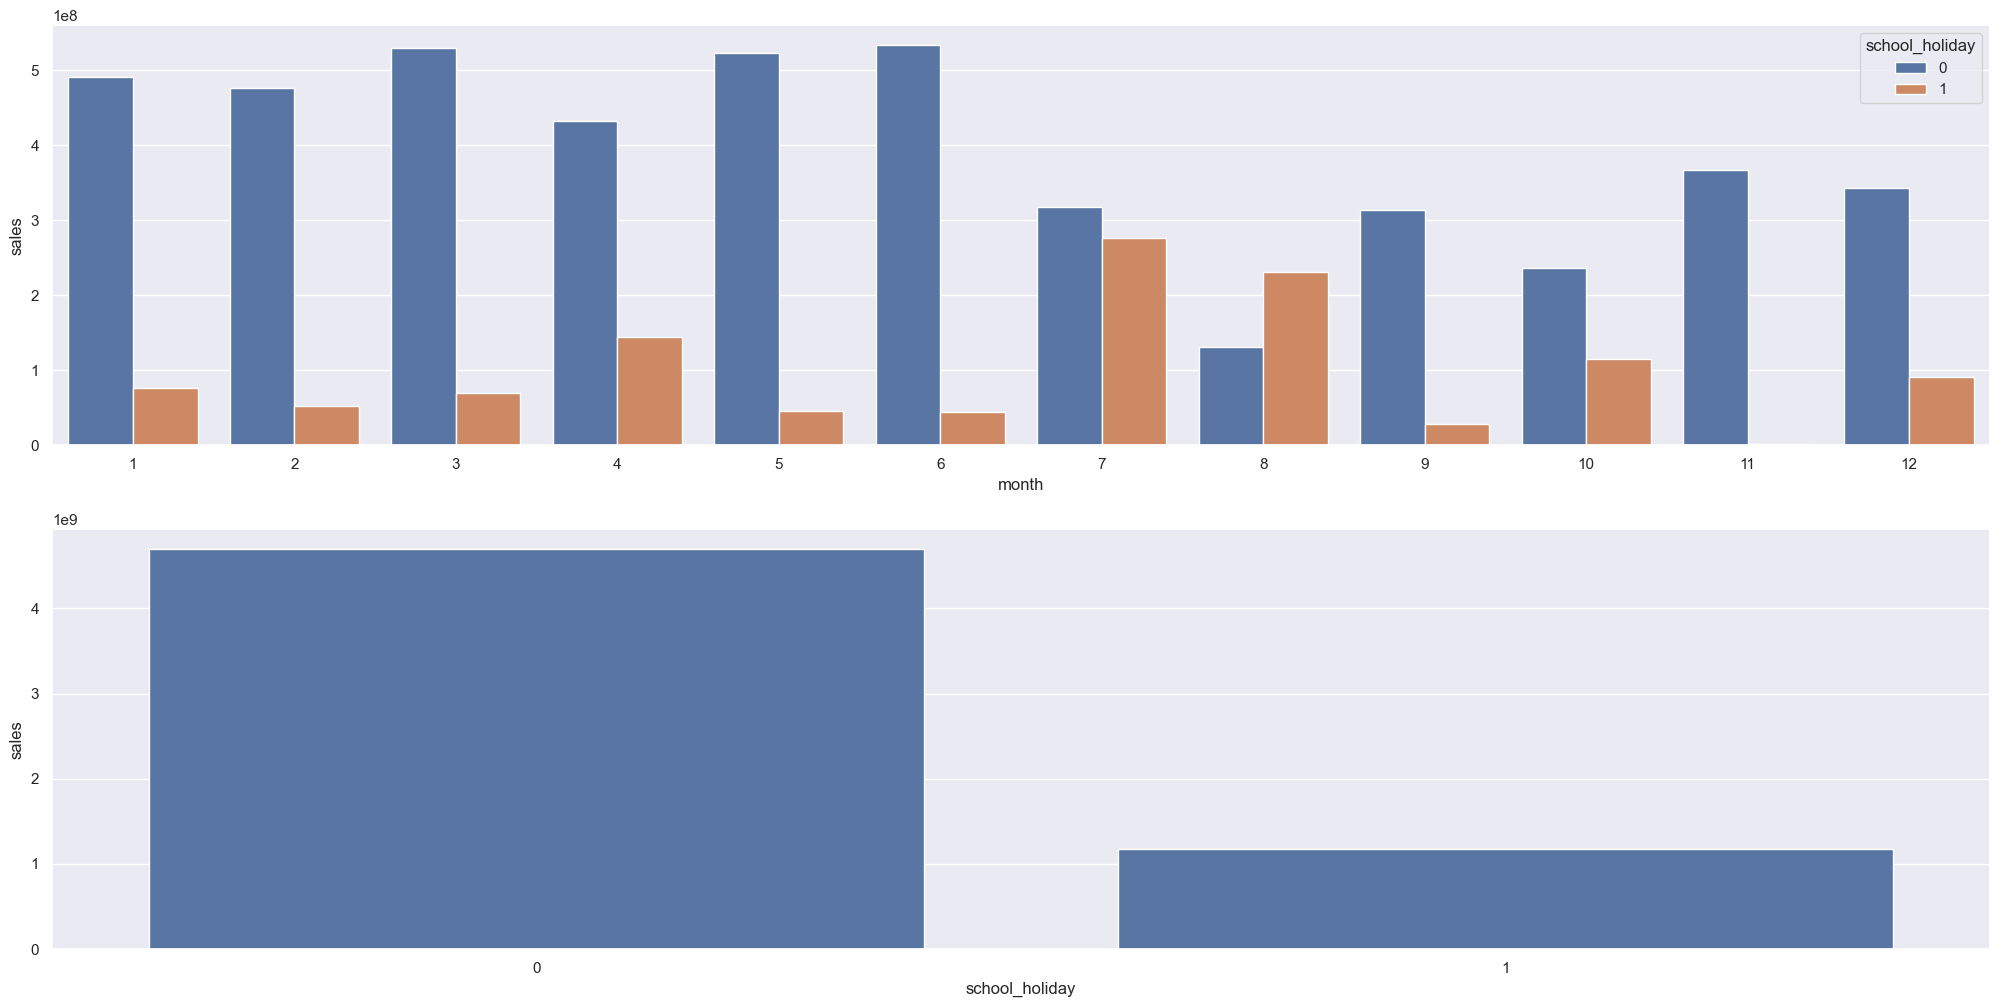

In [45]:
aux = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2)
plt.subplot(2,1,2)
sns.barplot(x='school_holiday',y='sales',data=aux)

#### 4.2.1 Summary of Hypotheses

In [46]:
from tabulate import tabulate
tab =[['Hipoteses', 'Conclusion', 'Relevancy'],
 ['H1', 'Falsa', 'Baixa'],
 ['H2', 'Falsa', 'Media'],
 ['H3', 'Falsa', 'Media'],
 ['H4', 'Falsa', 'Baixa'],
 ['H5', '-', '-'],
 ['H7', 'Falsa', 'Baixa'],
 ['H8', 'Falsa', 'Media'],
 ['H9', 'Falsa', 'Alta'],
 ['H10', 'Falsa', 'Alta'],
 ['H11', 'Verdadeira', 'Alta'],
 ['H12', 'Verdadeira', 'Alta'],
 ['H13', 'Verdadeira', 'Baixa'],
 ]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


In [47]:
#cols_not_selected_boruta

In [48]:
#cols_selected_boruta

## 4.3 Análise Multivariada

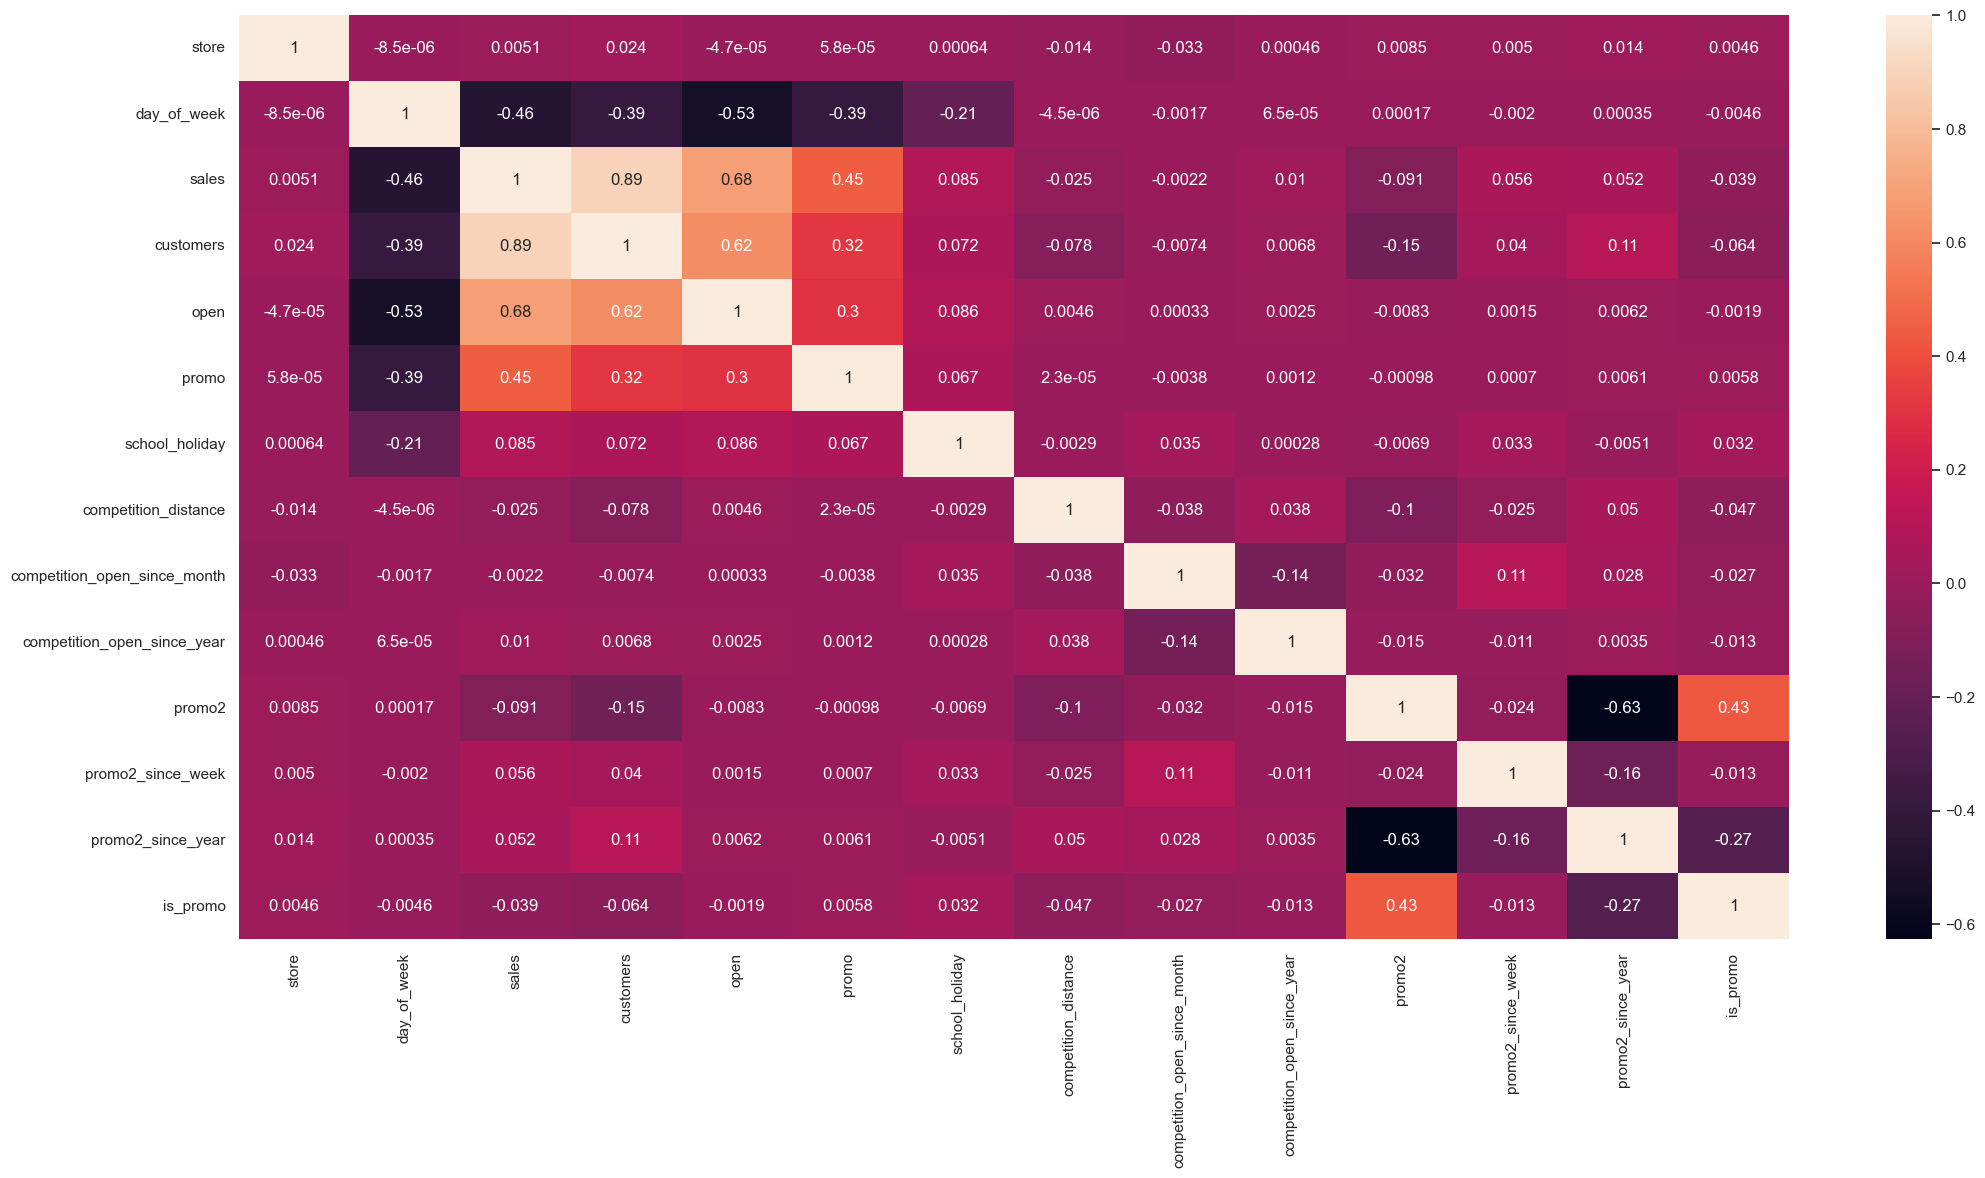

In [49]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

<Axes: >

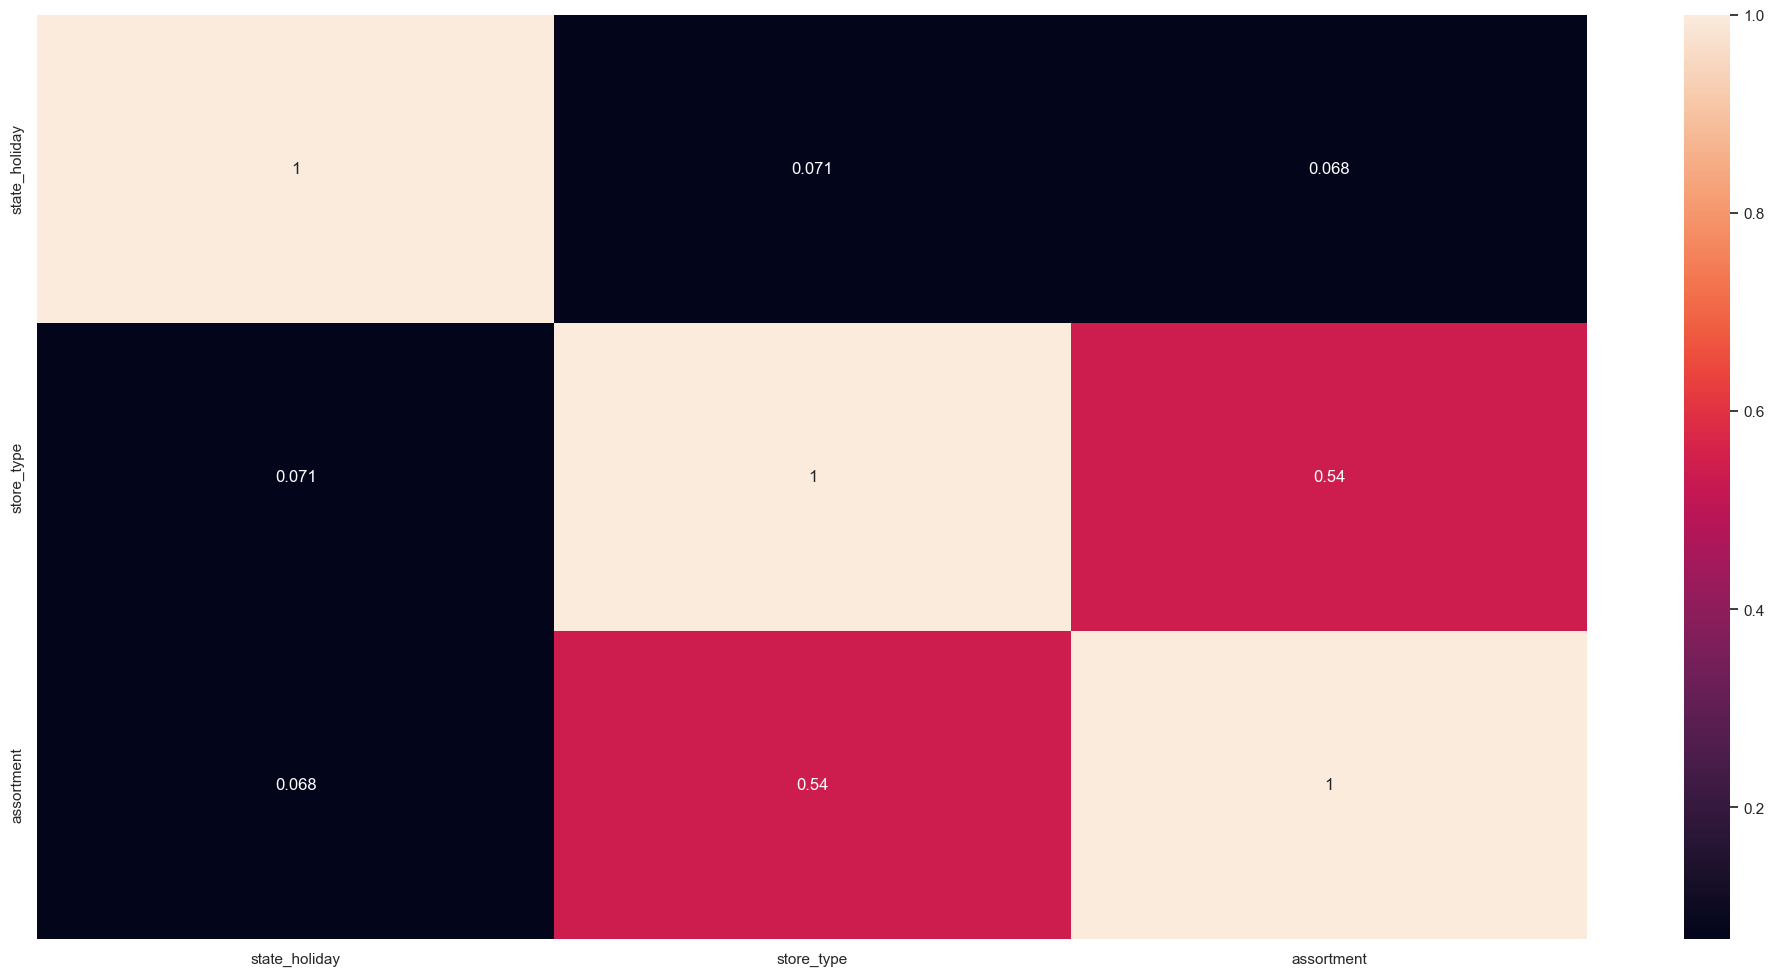

In [50]:
a = df4.select_dtypes( include='object' )
 # Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
 # Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
 'store_type': [a4, a5, a6],
 'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

## 5.0 NORMALIZATION

In [51]:
df5=df4.copy()

### 5.2 RESCALING

In [52]:
a = df5.select_dtypes(include = ['int64','float64'])

In [53]:
rs = RobustScaler()
mms = MinMaxScaler()

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open( r'parameter\competition_distance_scaler.pkl', 'wb') )

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open( r'parameter\competition_time_month_scaler.pkl', 'wb') )

df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( rs, open( r'parameter\promo_time_week_scaler.pkl', 'wb') )

df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open( r'parameter\year_scaler.pkl', 'wb') )

#### 5.3.1 Enconding

In [54]:

# state_holiday - one hot enconding
df5 = pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])
# store_type - labelEnconding
le = LabelEncoder()
df5['store_type']=le.fit_transform(df5['store_type'])
pickle.dump( le, open( r'parameter\store_type_scaler.pkl', 'wb') )
# assortment - Ordinal Encoding
df5['assortment'].drop_duplicates()
assortment_dict = {'basic':1,
                   'extra':2,
                   'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [55]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [56]:
# month
# day
# week of year
# day of week

### 5.3.2. Nature Transformation

In [57]:
df5['sales']=np.log1p(df5['sales'])

In [58]:
#day of week
df5['day_of_week_sin']=df5['day_of_week'].apply(lambda x:np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos']=df5['day_of_week'].apply(lambda x:np.cos(x*(2.*np.pi/7)))

df5['month_sin']=df5['month'].apply(lambda x:np.sin(x*(2.*np.pi/12)))
df5['month_cos']=df5['month'].apply(lambda x:np.cos(x*(2.*np.pi/12)))

df5['day_sin']=df5['day'].apply(lambda x:np.sin(x*(2.*np.pi/30)))
df5['day_cos']=df5['day'].apply(lambda x:np.cos(x*(2.*np.pi/30)))

df5['week_of_year_sin']=df5['week_of_year'].apply(lambda x:np.sin(x*(2.*np.pi/52)))
df5['week_of_year_cos']=df5['week_of_year'].apply(lambda x:np.cos(x*(2.*np.pi/52)))

In [59]:
df5.sample(10)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
115613,769,7,2015-04-19,9.362632,0,0,1,2,-0.240323,4,2015,1,48,2012,1,1.0,4,19,16,2015-15,2015-04-01,-0.216216,2012-11-19,0.571754,0,0,0,1,-2.449294e-16,1.000000,8.660254e-01,-0.500000,-7.431448e-01,-0.669131,9.350162e-01,-0.354605
227543,84,4,2015-01-08,9.406483,1,0,0,3,1.529032,8,2014,0,2,2015,0,1.0,1,8,2,2015-01,2014-08-01,-0.148649,2015-01-05,0.287016,0,0,0,1,-4.338837e-01,-0.900969,5.000000e-01,0.866025,9.945219e-01,-0.104528,2.393157e-01,0.970942
546958,279,3,2014-02-26,8.557183,0,0,3,3,-0.001613,2,2014,1,40,2012,0,0.5,2,26,9,2014-08,2014-02-01,-0.216216,2012-09-24,0.455581,0,0,0,1,4.338837e-01,-0.900969,8.660254e-01,0.500000,-7.431448e-01,0.669131,8.854560e-01,0.464723
18138,299,3,2015-07-15,9.075780,1,0,3,3,5.854839,9,2012,0,29,2015,0,1.0,7,15,29,2015-28,2012-09-01,0.243243,2015-07-13,0.287016,0,0,0,1,4.338837e-01,-0.900969,-5.000000e-01,-0.866025,1.224647e-16,-1.000000,-3.546049e-01,-0.935016
897326,537,4,2013-04-18,8.266164,0,0,0,1,-0.279032,5,2002,1,1,2012,1,0.0,4,18,16,2013-15,2002-05-01,1.581081,2011-12-26,0.441913,0,0,0,1,-4.338837e-01,-0.900969,8.660254e-01,-0.500000,-5.877853e-01,-0.809017,9.350162e-01,-0.354605
707832,593,6,2013-10-05,8.958283,0,0,0,3,4.956452,3,2010,0,40,2013,0,0.0,10,5,40,2013-39,2010-03-01,0.364865,2013-09-30,0.287016,0,0,0,1,-7.818315e-01,0.623490,-8.660254e-01,0.500000,8.660254e-01,0.500000,-9.927089e-01,0.120537
88820,736,3,2015-05-13,8.437500,0,0,2,3,-0.109677,5,2015,1,14,2011,0,1.0,5,13,20,2015-19,2015-05-01,-0.216216,2011-03-28,0.776765,0,0,0,1,4.338837e-01,-0.900969,5.000000e-01,-0.866025,4.067366e-01,-0.913545,6.631227e-01,-0.748511
245187,466,1,2014-12-22,9.474933,0,1,0,3,0.125806,3,2003,0,52,2014,0,0.5,12,22,52,2014-51,2003-03-01,1.716216,2014-12-22,0.287016,0,0,0,1,7.818315e-01,0.623490,-2.449294e-16,1.000000,-9.945219e-01,-0.104528,-2.449294e-16,1.000000
804212,1083,4,2013-07-11,8.201934,0,1,3,3,1.485484,7,2013,1,5,2013,0,0.0,7,11,28,2013-27,2013-07-01,-0.216216,2013-01-28,0.339408,0,0,0,1,-4.338837e-01,-0.900969,-5.000000e-01,-0.866025,7.431448e-01,-0.669131,-2.393157e-01,-0.970942
858516,752,4,2013-05-23,8.176392,0,0,0,1,-0.219355,3,2013,1,31,2013,1,0.0,5,23,21,2013-20,2013-03-01,-0.189189,2013-07-29,0.264237,0,0,0,1,-4.338837e-01,-0.900969,5.000000e-01,-0.866025,-9.945219e-01,0.104528,5.680647e-01,-0.822984


### 6.0 FEATURE SELECTION

In [60]:
df6 = df5.copy()

In [61]:
cols_drop = ['week_of_year','day','month','day_of_week','competition_since','year_week','promo_since']
df6 = df6.drop(cols_drop,axis=1)

In [62]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [63]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']
#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [64]:
# Monkey-patch np.int to int
#np.int = int
#np.float = float

# training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()

# Define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=1)

# Define Boruta and fit it to your data
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
#boruta.fit(X_train_n, y_train_n)

#### 6.2.1 Best Features from Boruta

In [65]:
#cols_selected = boruta.support_.tolist()
# best features
#X_train_fs = X_train.drop(['date','sales'],axis=1)
#cols_selected_boruta = X_train.iloc[:,cols_selected].columns.to_list()

#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_borura))

In [66]:
#cols_selected_boruta

In [67]:
#cols_not_selected_boruta

In [68]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']
 # columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

## 7.0 MACHINE LEARNING MODELLING

In [69]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]
#Time series Data preparation
x_training = X_train[cols_selected_boruta_full]

### 7.1 Average Model

In [70]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns ={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2, how ='left', on ='store')
yhat_baseline = aux1['predictions']

baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


### 7.2 Linear Regression Model

In [71]:
#model
lr = LinearRegression().fit(x_train,y_train)
#prediction
yhat_lr=lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


#### 7.2.1 Linear Regressions Cross Validation

In [72]:
lr_result_cv = cross_validation(x_training, 5, 'LinearRegression', lr,verbose=False)
lr_result_cv

,MAE CV,MAPE CV,RMSE CV
0,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


### 7.3 Linear Regression Regularized Model

In [73]:
#model
lrr = Lasso(alpha = 0.01).fit(x_train,y_train)
#prediction
yhat_lrr=lrr.predict(x_test)

#performance
lrr_result =ml_error('Linear Regression - Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


#### 7.3.1 Linear Regresssion Regularized Model Cross Validation

In [74]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr,verbose=False)
lrr_result_cv

,MAE CV,MAPE CV,RMSE CV
0,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


#### 7.4 Random Forest

In [75]:
from sklearn.ensemble import RandomForestRegressor

In [76]:
#model
rf = RandomForestRegressor(n_estimators = 100, n_jobs=1, random_state = 42).fit(x_train,y_train)
#prediction
yhat_rf=rf.predict(x_test)

#performance
rf_result = ml_error('RandomForestRegressor',np.expm1(y_test),np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,679.468166,0.099901,1010.910642


#### 7.4.1 Random Forest Cross Validation

In [77]:
rf_result_cv = cross_validation(x_training, 5, 'RandomForestRegressor', rf,verbose=False)
rf_result_cv

,MAE CV,MAPE CV,RMSE CV
0,836.84+/-217.64,0.12+/-0.02,1254.47+/-316.77


#### 7.5 XGBoost Regressor

In [78]:
import xgboost as xgb

In [79]:
#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators=100, eta = 0.01, max_depth = 10, subsample = 0.7, colsample_bytee = 0.9).fit(x_train,y_train)
#prediction
yhat_xgb=model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost',np.expm1(y_test),np.expm1(yhat_xgb))
xgb_result


C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [21:44:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


,Model Name,MAE,MAPE,RMSE
0,XGBoost,1695.785983,0.251783,2478.398037


#### 7.5.1 XGBoost Regressor Cross Validation

In [80]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb,verbose=False)
xgb_result_cv

C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [21:44:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [21:44:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [21:44:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsamp

,MAE CV,MAPE CV,RMSE CV
0,1860.64+/-291.01,0.25+/-0.01,2685.39+/-429.0


### 7.6 Compare Model's Performance

In [81]:
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,RandomForestRegressor,679.468166,0.099901,1010.910642
0,XGBoost,1695.785983,0.251783,2478.398037


#### 7.6.1 Compare Model's Performance Cross Validation

In [82]:
modeling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modeling_result_cv

,MAE CV,MAPE CV,RMSE CV
0,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26
0,836.84+/-217.64,0.12+/-0.02,1254.47+/-316.77
0,1860.64+/-291.01,0.25+/-0.01,2685.39+/-429.0


In [83]:
model = Lasso(alpha = 0.01)
a = cross_validation(x_training, 5,'Linear Regression',model,verbose = False)

In [84]:
a

,MAE CV,MAPE CV,RMSE CV
0,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


### 8.0 HYPERPARAMETER FINE TUNNING

#### 8.1 Random Search

In [85]:
import random


param = {'n_estimators': [1500,1700,2500,3000,3500],
        'eta': [0.01,0.03],
        'max_depth': [3,5,9],
        'subsample': [0.1,0.5,0.7],
        'colsample_bytee': [0.3,0.7,0.9],
        'min_child_weight': [3,8,15]}
MAX_EVAL = 10



In [86]:
final_result = pd.DataFrame()
for i in range(MAX_EVAL):
    #choose values for parameters randonly
    hp = {k: random.sample(v,1)[0] for k,v in param.items()}
    print(hp)
    #model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators=hp['n_estimators'], eta = hp['eta'], max_depth = hp['max_depth'], subsample = hp['subsample'], colsample_bytee = hp['colsample_bytee'], min_child_weight = hp['min_child_weight']).fit(x_train,y_train)
    #prediction
    yhat_xgb=model_xgb.predict(x_test)
    
    #performance
    result=cross_validation(x_training, 2, 'XGBoost Regressor',model_xgb, verbose = False)
    final_result = pd.concat([final_result,result])
final_result

{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 8}


C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [21:44:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [21:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [21:50:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsamp

{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 8}


C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [21:52:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [21:54:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [21:55:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsamp

{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 3}


C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [21:57:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [21:59:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:00:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsamp

{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytee': 0.3, 'min_child_weight': 8}


C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:02:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:04:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:06:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsamp

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 8}


C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:08:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:11:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:14:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsamp

{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytee': 0.9, 'min_child_weight': 8}


C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:17:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:18:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:19:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsamp

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.3, 'min_child_weight': 3}


C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:21:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:23:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:25:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsamp

{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytee': 0.9, 'min_child_weight': 3}


C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:27:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:29:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:30:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsamp

{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 3}


C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:32:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:34:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:35:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsamp

{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 8}


C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:36:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:41:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsamp

,MAE CV,MAPE CV,RMSE CV
0,841.17+/-114.37,0.11+/-0.01,1209.87+/-190.44
0,1319.54+/-53.99,0.18+/-0.0,1910.18+/-93.52
0,1592.84+/-50.54,0.22+/-0.0,2320.67+/-92.64
0,1612.72+/-49.45,0.22+/-0.0,2357.32+/-93.01
0,819.62+/-85.83,0.11+/-0.01,1192.53+/-151.89
0,1392.68+/-52.66,0.19+/-0.0,2028.18+/-90.74
0,915.09+/-88.06,0.13+/-0.01,1302.18+/-150.89
0,1186.07+/-52.85,0.16+/-0.0,1740.61+/-106.54
0,1373.9+/-52.11,0.19+/-0.0,1992.42+/-92.36
0,847.51+/-98.32,0.11+/-0.01,1226.28+/-167.78


#### 8.2 Final Model

In [87]:

param_tuned = {'n_estimators':3500,
        'eta':0.03,
        'max_depth':9,
        'subsample':0.5,
        'colsample_bytee':0.3,
        'min_child_weight':15}

In [88]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators=param_tuned['n_estimators'], eta = param_tuned['eta'], max_depth = param_tuned['max_depth'], subsample = param_tuned['subsample'], colsample_bytee = param_tuned['colsample_bytee'], min_child_weight = param_tuned['min_child_weight']).fit(x_train,y_train)
#prediction
yhat_xgb_tuned= model_xgb_tuned.predict(x_test)
    
#performance
xgb_result_tuned = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tuned


C:\Users\israb\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\xgboost\core.py:160: UserWarning: [22:43:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,626.38113,0.090122,920.95137


#### MAE, MAPE, RMSE MPE

In [89]:
np.expm1(y_test).min()

569.0000000000002

In [90]:
np.expm1(y_test).max()

41550.99999999998

In [91]:
np.expm1(y_test).max() - np.expm1(y_test).min()

40981.99999999998

In [92]:
np.mean(np.expm1(y_test))

6995.162576094309

In [93]:
mape = 626/6995
mape

0.08949249463902788

In [94]:
rmse = 920.95/6995
rmse

0.13165832737669764

In [95]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.008198960693503107

### 9.0 Error Interpretation

In [96]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales']=np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

C:\Users\israb\AppData\Local\Temp\ipykernel_19684\1203588460.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales']=np.expm1(df9['sales'])
C:\Users\israb\AppData\Local\Temp\ipykernel_19684\1203588460.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


### 9.1 Business Performance

In [97]:
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x : mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x : mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAPE'})

#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on = 'store')
df92 = pd.merge(df91,df9_aux3, how='inner',on='store')

#Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]


In [98]:
df92.sort_values('MAPE',ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,103685.734375,100346.748471,107024.720279,3338.985904,0.547580
908,909,235517.515625,228025.521888,243009.509362,7491.993737,0.502680
875,876,203655.640625,199747.307331,207563.973919,3908.333294,0.286643
594,595,380777.000000,376765.216137,384788.783863,4011.783863,0.273564
549,550,240916.125000,239603.050240,242229.199760,1313.074760,0.254734


<Axes: xlabel='store', ylabel='MAPE'>

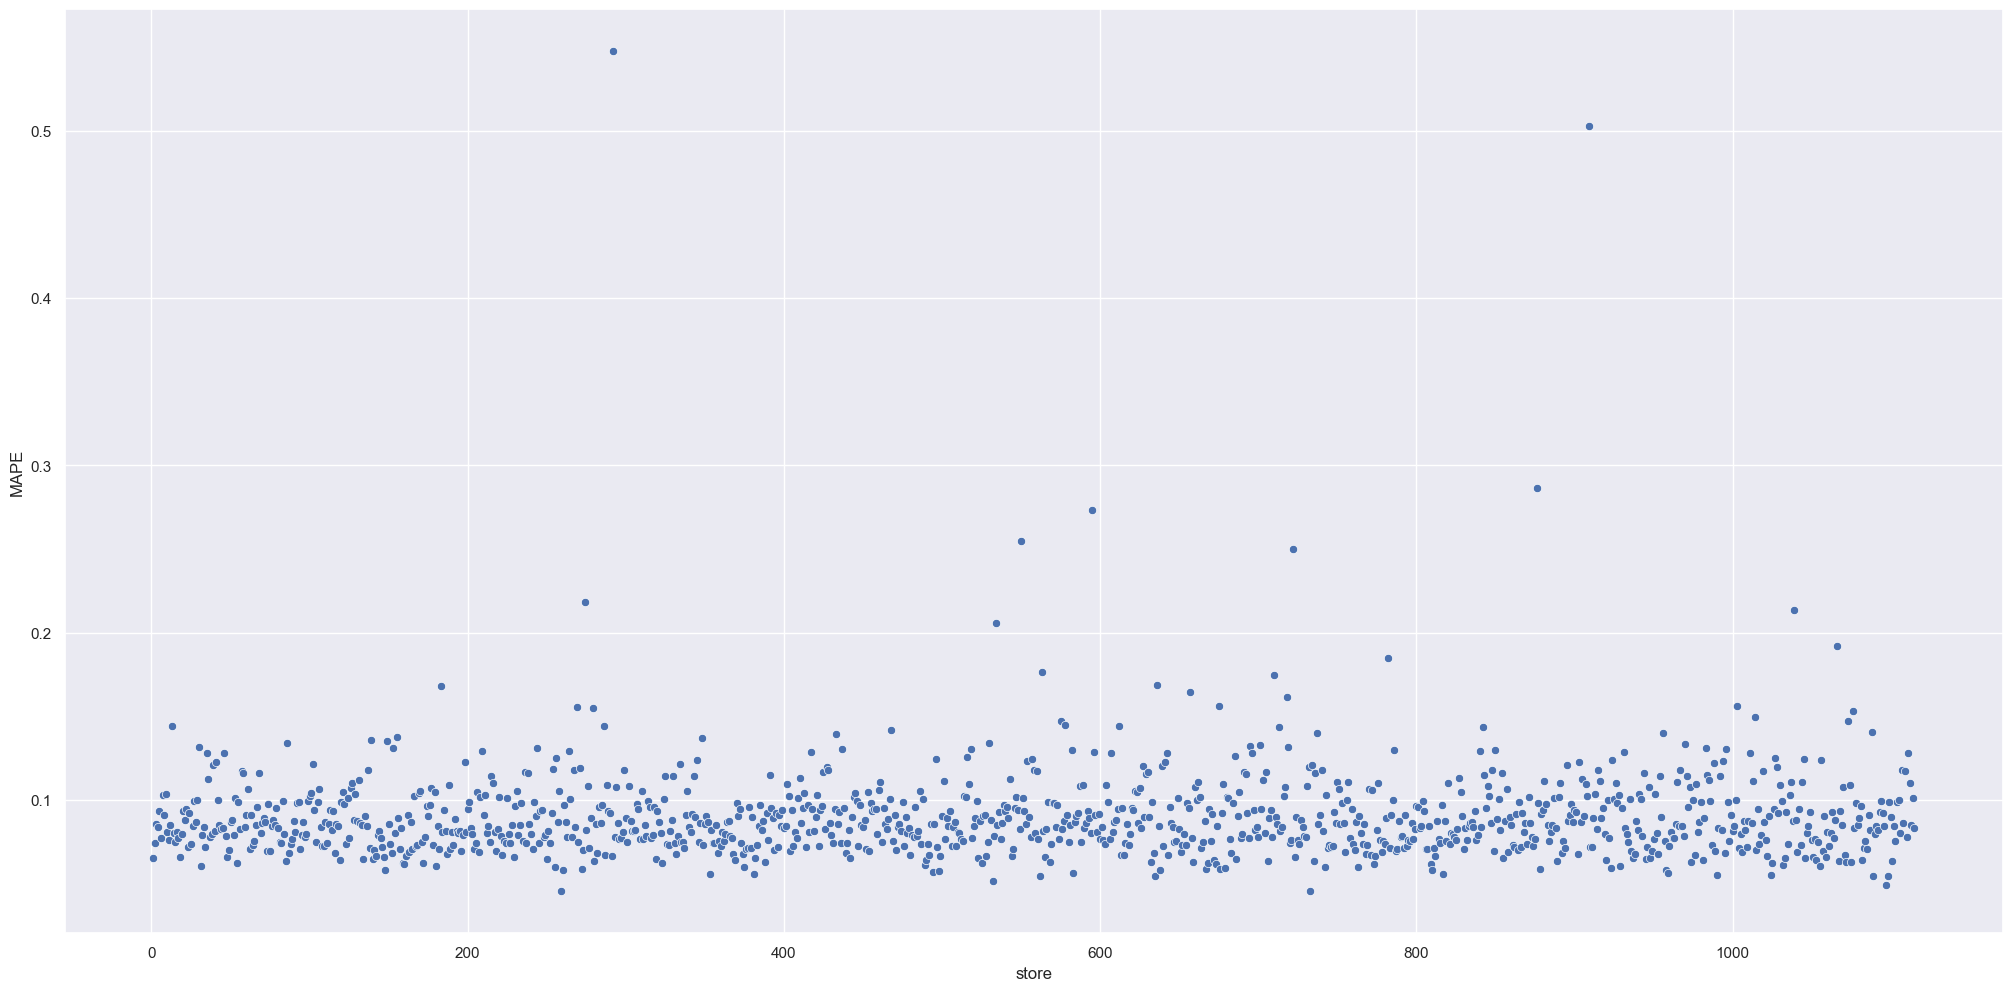

In [99]:
sns.scatterplot(x='store',y='MAPE',data = df92)

#### 9.2 Total Performance

In [100]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis = 0).reset_index().rename(columns ={'Index':'Scenario',0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,index,Values
0,predictions,"R$282,962,688.00"
1,worst_scenario,"R$282,260,171.21"
2,best_scenario,"R$283,665,236.60"


#### 9.3 Machine Learning Performance

In [101]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate']=df9['predictions']/df9['sales']


C:\Users\israb\AppData\Local\Temp\ipykernel_19684\747178153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\israb\AppData\Local\Temp\ipykernel_19684\747178153.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate']=df9['predictions']/df9['sales']


C:\Users\israb\AppData\Local\Temp\ipykernel_19684\2529414934.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df9['error'])


TypeError: scatterplot() got multiple values for argument 'data'

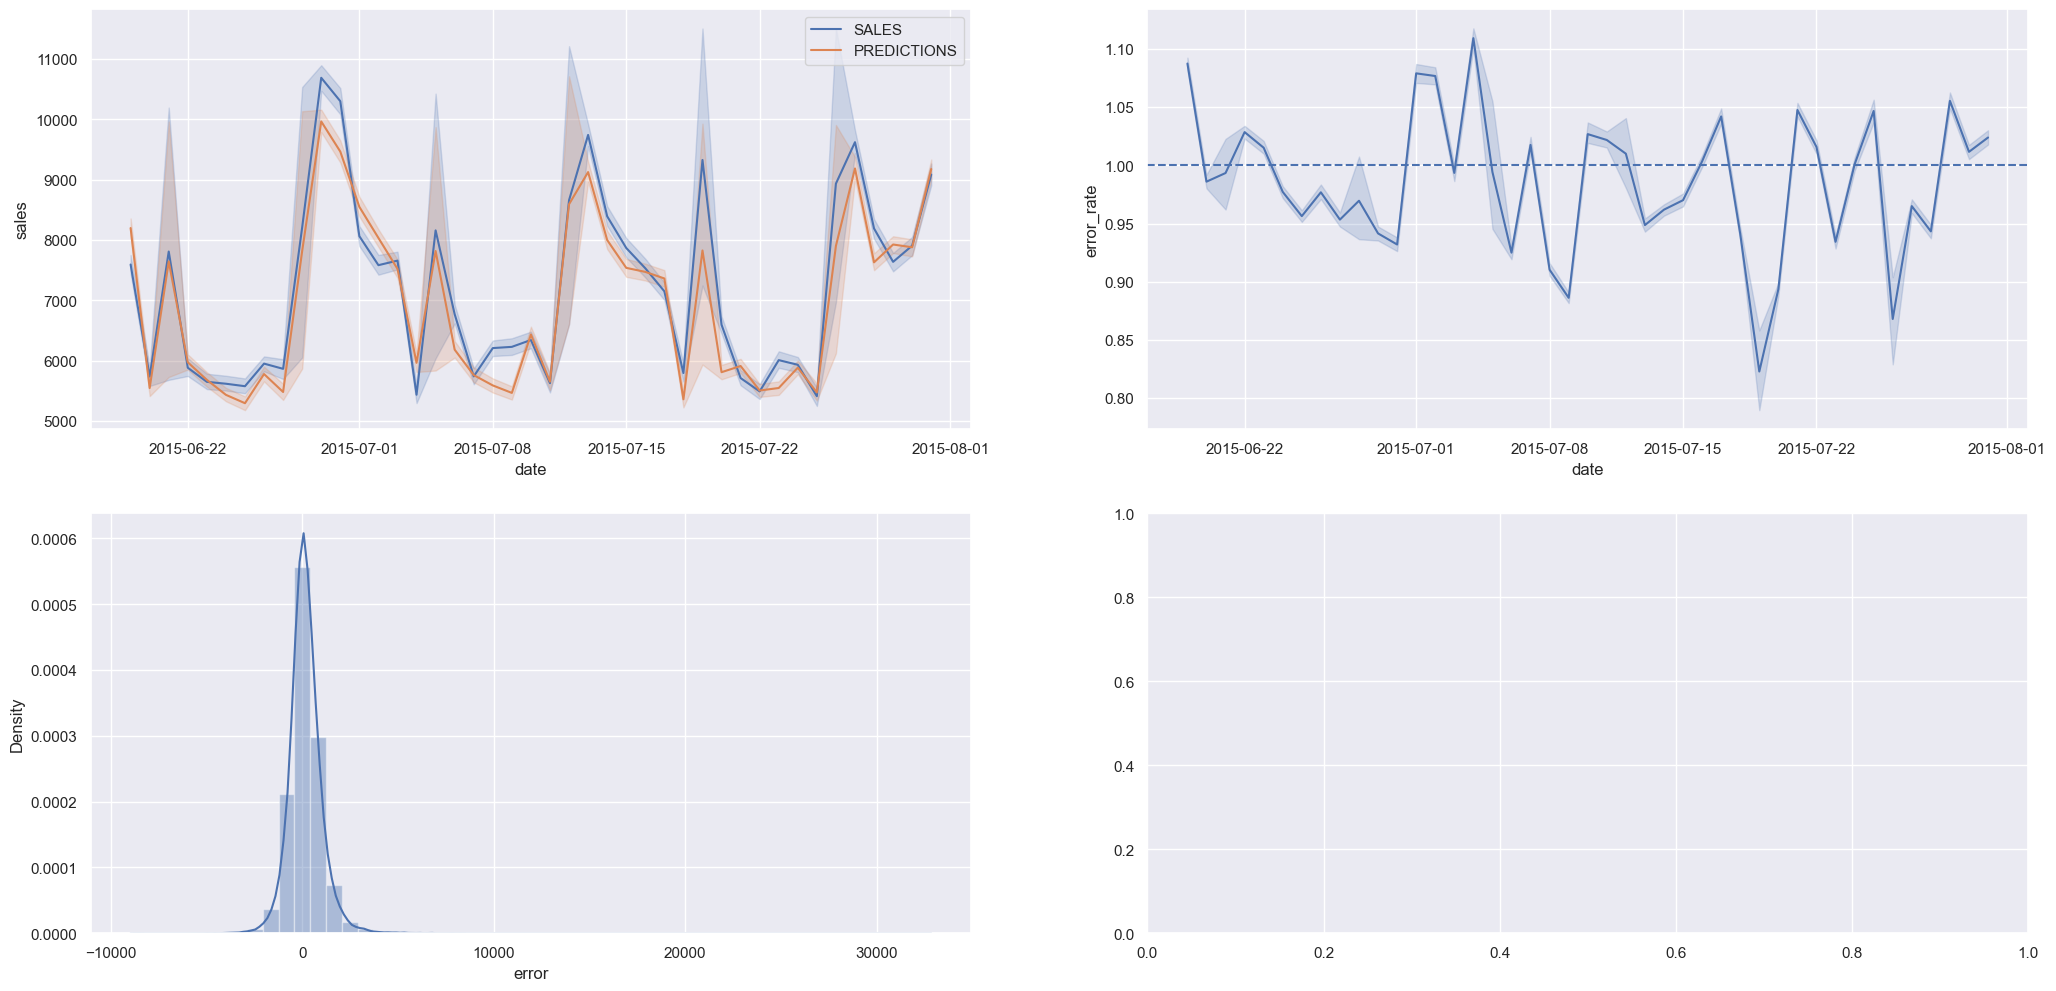

In [102]:
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data =df9, label ='SALES')
sns.lineplot(x='date',y='predictions',data =df9, label ='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data =df9)
plt.axhline(1,linestyle = '--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot( df9['predictions'], df9['error'], data=df9)


In [147]:
# 1. Calculation of MAE and MAPE by store 
df_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(
    lambda x: mean_absolute_error(x['sales'], x['predictions'])
).reset_index().rename(columns={0: 'MAE'})

df_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(
    lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])
).reset_index().rename(columns={0: 'MAPE'})

# 2. Metrics by store
df_store_metrics = pd.merge(df_aux1, df_aux2, on='store')


df_final = df9.copy()

# Drop old scenario coluns
cols_to_drop = ['worst_scenario', 'best_scenario', 'MAE', 'MAPE']
df_final = df_final.drop(columns=[c for c in cols_to_drop if c in df_final.columns])

# Final Merge
df_final = pd.merge(df_final, df_store_metrics, on='store', how='left')

# Calculations
df_final['worst_scenario'] = df_final['predictions'] - df_final['MAE']
df_final['best_scenario'] = df_final['predictions'] + df_final['MAE']

# Maping encoding
store_type_map = {0: 'a', 1: 'b', 2: 'c', 3: 'd'}
assortment_map = {1: 'basic', 2: 'extra', 3: 'extended'}

df_final['store_type'] = df_final['store_type'].map(store_type_map)
df_final['assortment'] = df_final['assortment'].map(assortment_map)

# Export final database for visualization
df_final.to_csv('rossmann_tableau_final.csv', index=False)
print("New df_final sucess generated!")

Novo df_final gerado com sucesso!
